#Introduction to GANs

Generative Adversarial Networks (GANS) are an approach to generative modeling using deep learning methods, such as convolutional neural networks.

This picture is from the website thispersondoesexist: https://thispersondoesnotexist.com/
\
Each time the GAN generates a random picture of a person from a random vector to obtain a picture that looks pretty much like a real person.
\
The GAN in pretrained on StyleGAN2.

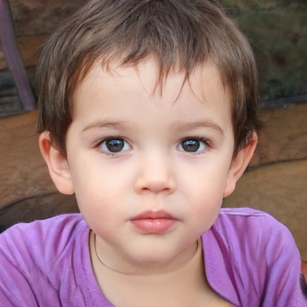

GANS are composed of two sub-models: 
- The generator model that is trained train to generate new (fake) examples  
- The discriminator model that tries to classify examples as either real or fake (generated). 
\
Both models are trained together in a competitive game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.
\
In short, the generator tries to fool the discriminator by trying to generate images that look like real samples, while the discriminator tries to predict the fake and real examples.
\
Both models are randomly initialized and are respectively updated simultaneously trying to overcome each other.
\
The training does not stop at a certain point, but it is useless to continue training if the generator overcame the discriminator and fooled it almost with every new generated example.
\
Below is the general architecture used in GANs


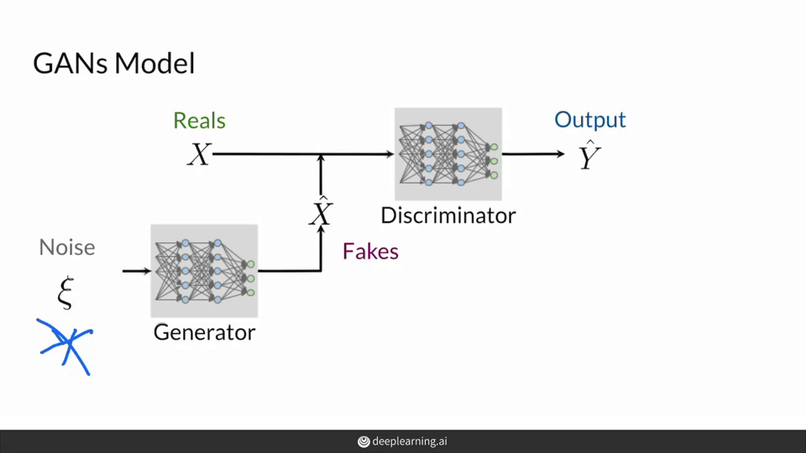

The BCE loss function below is used to update the discriminator and the generator.
\
In fact, when updating the discriminator, the generator parameters and fixed. The discriminator parameters are updated using the real and fake examples to help the discriminator distinguish between reals and fakes.
\
As for the generator, its parameters are updated while keeping the discriminator ones constant. But the main difference is that the generator only uses the loss function its generated images. The generator wants the output of the discriminator to be as close to 1 (real) as possible, while the discriminator wants it to be as close to 0 as possible (fake). The cost function calculated on those fake examples is used to update the generator parameters in order for it to improve its generation.

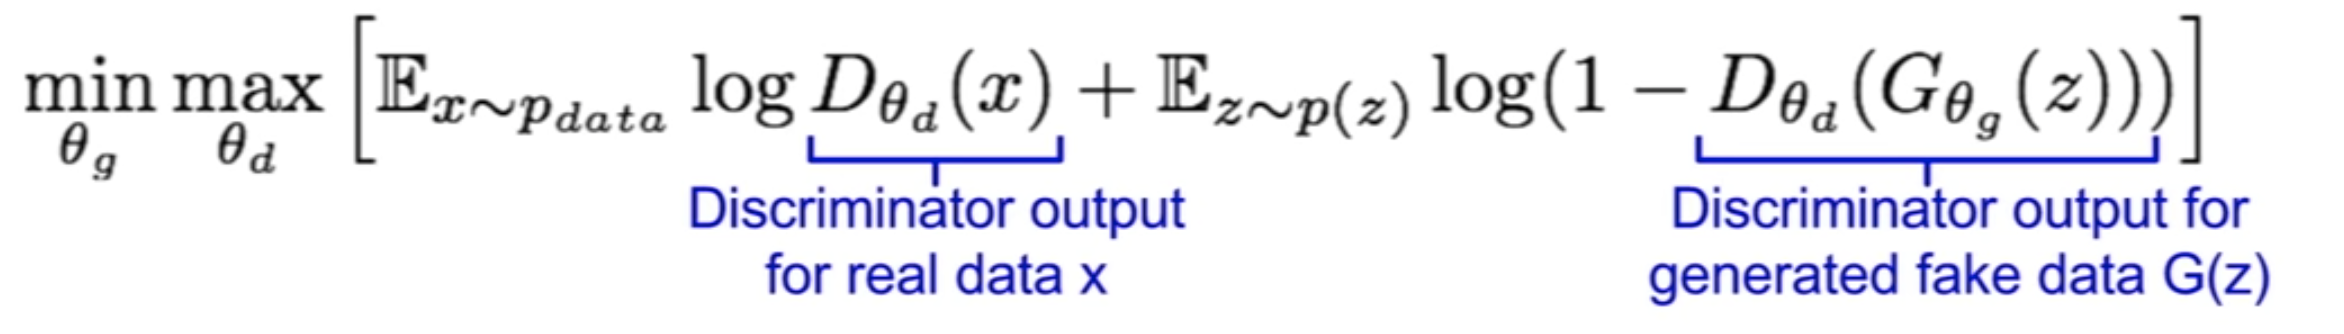

Below are 2 schemes describing the updateing process of the 2 networks

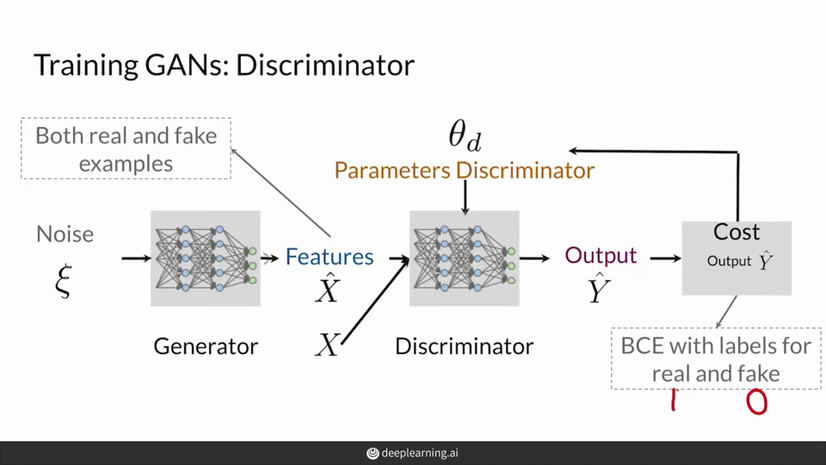

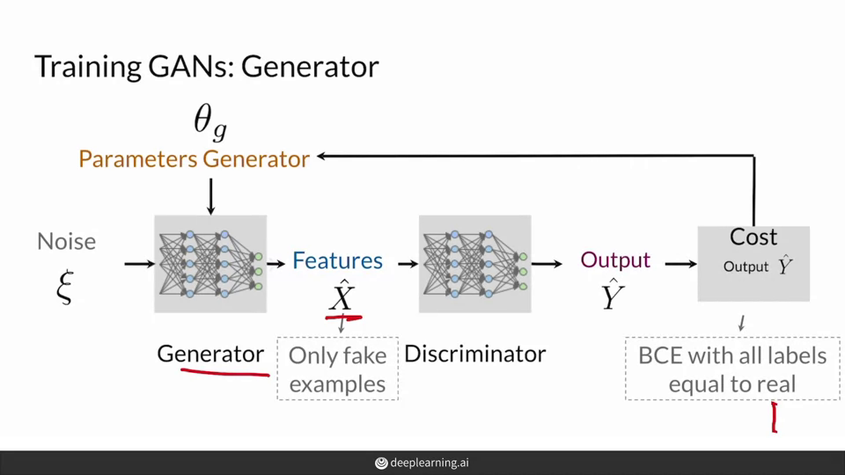

# Load data and packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from os import listdir
from matplotlib import image
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import Resize, CenterCrop
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch
import random
from torch.nn import Sequential



In [ ]:
# extract the zipped files into directory
with zipfile.ZipFile('../input/generative-dog-images/all-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
with zipfile.ZipFile('../input/generative-dog-images/Annotation.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
#check folders in current location 
import os
print(os.listdir("."))

['Annotation', '__notebook_source__.ipynb', 'all-dogs', '__MACOSX']


# Set Environment

In [ ]:
start = time()

In [ ]:
#control random generation 
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Set and train GAN architecture

In [ ]:
#create a class for Data generator
class DataGenerator(Dataset):
  #initialize the class giving: directory, the transformations to apply to the Data and number of samples
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples
        #load images in the subfoler all dogs
        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            #check if the data exists in the directory          
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        #the possible image extensions that can be loaded
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        #check if the extension of the file exists in the list 
        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)
        #Set pieline of transformations:  resize the picture to size 64x64 and crop 
        required_transforms = torchvision.transforms.Compose([
                transforms.Resize(64), #Resize the input image to the given size
                CenterCrop(64),  #Crops the given image at the center
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)): #generates all the file names fnames in the directory
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]: #iterate through the file names
                path = os.path.join(root, fname) #the full file path
                paths.append(path)

        for path in paths:
          #check if image extension is valid
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0] #get the all-dogs data repository
                #get the repository of the class
                annotation_dirname = next(
                        dirname for dirname in os.listdir('./Annotation') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                #get the file name of the annotated image
                annotation_filename = os.path.join('./Annotation',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                #get the box of the cropped image
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    #object_img = object_img.resize((64,64), Image.ANTIALIAS)
                    imgs.append(object_img)
        return imgs
    #check/vizulaise a sample
    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    #check the ken of a sample
    def __len__(self):
        return len(self.samples)

In [ ]:
%%time
#databse directory
database = './all-dogs'
#transformations to convert the data to tensor
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#the train data
train_data = DataGenerator(database, transform=transform,n_samples=25000)

#generate the train data
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)

CPU times: user 1min 11s, sys: 2.64 s, total: 1min 13s
Wall time: 1min 14s


In [ ]:
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
      #normalize the input vectors by their standard deviation
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [ ]:
def show_generated_img_all():
  #swhow 32 generated images by the GANs
    gen_z = torch.randn(32, nz, 1, 1, device=device) #generate a random vector
    gen_images = netG(gen_z).to("cpu").clone().detach() #pass the random vector to the GAN
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1) #transpose the vector in order to get the desired format for the input
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    #plot the generated image
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)

In [ ]:
def show_generated_img():
  #show a generated image
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

In [ ]:
class MinibatchStdDev(th.nn.Module):
    #this layer is a standard deviation layer

    def __init__(self):
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):

        #forward pass of the standard deviation layer
        # x is the input activation volume
        #alpha is used for numerical stability
        #y is output

        batch_size, _, height, width = x.shape # the shape is [B C H W] 
        
        y = x - x.mean(dim=0, keepdim=True) #Subtract mean by batch
        
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha) #  standard deviation over batch of size [1 C  H  W]

        y = y.mean().view(1, 1, 1, 1) #  average over feature_maps and pixels

        y = y.repeat(batch_size,1, height, width) # the size is [B 1 H W] after Replication over group and pixels

       
        y
        new_feature = torch.cat([x, y], 1) # mix both features  Append as new feature_map.
        return new_feature

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, for a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
   
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))

        self.pixnorm = PixelwiseNorm()
    def forward(self, x):
        seq_bloc= Sequential(self.conv1, F.leaky_relu(),
                             self.conv2, F.leaky_relu(),
                             self.pixnorm,
                             self.conv3, F.leaky_relu(),
                             self.pixnorm,
                             self.conv4, F.leaky_relu(),
                             self.pixnorm,
                             self.conv5, F.leaky_relu(),
                             self.pixnorm,
                             self.conv6, torch.tanh)
        y = seq_bloc(x)
        
        return y



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input size= [nchannels 64  64]
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
 
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)

        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats* 8 +1, 1, 2, 1, 0, bias=False))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
     
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)

        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)

        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        y = x.view(-1, 1)
        return (y)

In [ ]:
#set device to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#learning_rate lr for generator
lr = 0.0003
#learning_rate lr for discriminator
lr_d = 0.0001
beta1 = 0.5
#number of epochs
epochs = 2000 
#instantize generator and discriminator
netG = Generator(100, 32, 3).to(device) # The random vector Z is of size 100,  number of features=32, number of channels=3 (RGB)
netD = Discriminator(3, 48).to(device)  # The number of channels=3, number of features=48

criterion = nn.BCELoss() #error function Binary cross entropy to optimize

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) #optimizer for discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999)) #optimizer for Generator

#Set the learning rate of each parameter group with cosine annealing schedule
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//200, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//200, eta_min=0.00005)

nz = 100 #size of Z
#generate the random noise vector
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 1
fake_label = 0.0
batch_size = train_loader.batch_size

In [ ]:
#check active device
device

device(type='cuda')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[1/2000][0/692] Loss_D: 1.2899 Loss_G: 4.5728 D(x): 0.4467 D(G(z)): 0.4114 / 0.0015
[1/2000][500/692] Loss_D: 0.8169 Loss_G: 3.8324 D(x): 0.8149 D(G(z)): 0.0189 / 0.0047



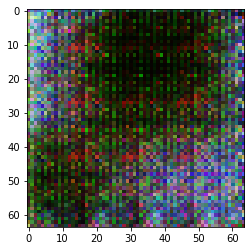

[2/2000][308/692] Loss_D: 0.7820 Loss_G: 2.6684 D(x): 0.5787 D(G(z)): 0.0432 / 0.0260



[3/2000][116/692] Loss_D: 1.0612 Loss_G: 2.0311 D(x): 0.5038 D(G(z)): 0.2441 / 0.0705
[3/2000][616/692] Loss_D: 0.8920 Loss_G: 2.4163 D(x): 0.6584 D(G(z)): 0.2025 / 0.0373



[4/2000][424/692] Loss_D: 0.9295 Loss_G: 2.1268 D(x): 0.6254 D(G(z)): 0.2054 / 0.0572



[5/2000][232/692] Loss_D: 0.7454 Loss_G: 2.3926 D(x): 0.6266 D(G(z)): 0.0876 / 0.0382



[6/2000][40/692] Loss_D: 0.8531 Loss_G: 2.5499 D(x): 0.6325 D(G(z)): 0.1149 / 0.0331
[6/2000][540/692] Loss_D: 0.8220 Loss_G: 2.0451 D(x): 0.5990 D(G(z)): 0.1181 / 0.0647



[7/2000][348/692] Loss_D: 1.0610 Loss_G: 0.9005 D(x): 0.3869 D(G(z)): 0.1014 / 0.3743



[8/2000][156/692] Loss_D: 0.9567 Loss_G: 1.9180 D(x): 0.6677 D(G(z)): 0.2126 / 0.0785
[8/2000][656/692] Loss_D: 0.9857 Loss_G: 1.6422 D(x): 0.4689 D(G(z)): 0.1740 / 0.1156



[9/2000][464/692] Loss_D: 0.8275 Loss_G: 1.7367 D(x): 0.5881 D(G(z)): 0.1348 / 0.1046



[10/2000][272/692] Loss_D: 0.8946 Loss_G: 1.4339 D(x): 0.5482 D(G(z)): 0.1605 / 0.1569



[11/2000][80/692] Loss_D: 1.0100 Loss_G: 1.3471 D(x): 0.4172 D(G(z)): 0.2073 / 0.1643
[11/2000][580/692] Loss_D: 0.8707 Loss_G: 1.9862 D(x): 0.6222 D(G(z)): 0.1851 / 0.0696



[12/2000][388/692] Loss_D: 0.9578 Loss_G: 2.1283 D(x): 0.5540 D(G(z)): 0.1975 / 0.0602



[13/2000][196/692] Loss_D: 0.8676 Loss_G: 1.4064 D(x): 0.4965 D(G(z)): 0.1083 / 0.1573



[14/2000][4/692] Loss_D: 0.8637 Loss_G: 1.7480 D(x): 0.5536 D(G(z)): 0.1455 / 0.1026
[14/2000][504/692] Loss_D: 0.9669 Loss_G: 1.7885 D(x): 0.6037 D(G(z)): 0.2295 / 0.0995



[15/2000][312/692] Loss_D: 0.8565 Loss_G: 1.3743 D(x): 0.5988 D(G(z)): 0.1758 / 0.1740



[16/2000][120/692] Loss_D: 0.8378 Loss_G: 1.6998 D(x): 0.6048 D(G(z)): 0.1642 / 0.1091
[16/2000][620/692] Loss_D: 0.8451 Loss_G: 1.7205 D(x): 0.6194 D(G(z)): 0.1797 / 0.1026



[17/2000][428/692] Loss_D: 0.8743 Loss_G: 1.7351 D(x): 0.5111 D(G(z)): 0.1382 / 0.1071



[18/2000][236/692] Loss_D: 0.8807 Loss_G: 1.5529 D(x): 0.5379 D(G(z)): 0.1387 / 0.1285



[19/2000][44/692] Loss_D: 0.9563 Loss_G: 1.4757 D(x): 0.5586 D(G(z)): 0.2087 / 0.1423
[19/2000][544/692] Loss_D: 0.9927 Loss_G: 1.5355 D(x): 0.5521 D(G(z)): 0.2188 / 0.1377



[20/2000][352/692] Loss_D: 0.9315 Loss_G: 1.3556 D(x): 0.4808 D(G(z)): 0.1539 / 0.1645



[21/2000][160/692] Loss_D: 1.1113 Loss_G: 0.9548 D(x): 0.3408 D(G(z)): 0.1363 / 0.3232
[21/2000][660/692] Loss_D: 1.0108 Loss_G: 1.5085 D(x): 0.5379 D(G(z)): 0.2379 / 0.1291



[22/2000][468/692] Loss_D: 1.1375 Loss_G: 1.2153 D(x): 0.2936 D(G(z)): 0.0652 / 0.2094



[23/2000][276/692] Loss_D: 0.8734 Loss_G: 1.6666 D(x): 0.5116 D(G(z)): 0.1380 / 0.1081



[24/2000][84/692] Loss_D: 1.0230 Loss_G: 1.5302 D(x): 0.3033 D(G(z)): 0.0834 / 0.1301
[24/2000][584/692] Loss_D: 0.8785 Loss_G: 2.0087 D(x): 0.6319 D(G(z)): 0.1872 / 0.0654



[25/2000][392/692] Loss_D: 0.8756 Loss_G: 1.5558 D(x): 0.5572 D(G(z)): 0.1708 / 0.1266



[26/2000][200/692] Loss_D: 0.9307 Loss_G: 1.5972 D(x): 0.6226 D(G(z)): 0.2426 / 0.1154



[27/2000][8/692] Loss_D: 0.9160 Loss_G: 1.2676 D(x): 0.5511 D(G(z)): 0.2016 / 0.2033
[27/2000][508/692] Loss_D: 1.0183 Loss_G: 1.4650 D(x): 0.6152 D(G(z)): 0.2710 / 0.1420



[28/2000][316/692] Loss_D: 0.9061 Loss_G: 1.6898 D(x): 0.6460 D(G(z)): 0.1916 / 0.1031



[29/2000][124/692] Loss_D: 0.8955 Loss_G: 1.6107 D(x): 0.5039 D(G(z)): 0.1519 / 0.1165
[29/2000][624/692] Loss_D: 0.8989 Loss_G: 1.6021 D(x): 0.5483 D(G(z)): 0.1740 / 0.1232



[30/2000][432/692] Loss_D: 1.0813 Loss_G: 1.3979 D(x): 0.3505 D(G(z)): 0.1150 / 0.1583



[31/2000][240/692] Loss_D: 1.0166 Loss_G: 1.4535 D(x): 0.5821 D(G(z)): 0.2974 / 0.1452



[32/2000][48/692] Loss_D: 0.9102 Loss_G: 1.7847 D(x): 0.4538 D(G(z)): 0.1367 / 0.0875
[32/2000][548/692] Loss_D: 1.1473 Loss_G: 2.1891 D(x): 0.6816 D(G(z)): 0.3635 / 0.0512



[33/2000][356/692] Loss_D: 1.1262 Loss_G: 2.1895 D(x): 0.5912 D(G(z)): 0.3407 / 0.0525



[34/2000][164/692] Loss_D: 0.9044 Loss_G: 1.7227 D(x): 0.6542 D(G(z)): 0.2008 / 0.1014
[34/2000][664/692] Loss_D: 0.8747 Loss_G: 1.5144 D(x): 0.5472 D(G(z)): 0.1617 / 0.1350



[35/2000][472/692] Loss_D: 0.9594 Loss_G: 1.2878 D(x): 0.4470 D(G(z)): 0.1545 / 0.1895



[36/2000][280/692] Loss_D: 0.9589 Loss_G: 1.4541 D(x): 0.4107 D(G(z)): 0.0912 / 0.1557



[37/2000][88/692] Loss_D: 0.9067 Loss_G: 1.1777 D(x): 0.4761 D(G(z)): 0.1357 / 0.2188
[37/2000][588/692] Loss_D: 0.9283 Loss_G: 2.0629 D(x): 0.5526 D(G(z)): 0.1808 / 0.0638



[38/2000][396/692] Loss_D: 0.9311 Loss_G: 1.4391 D(x): 0.4780 D(G(z)): 0.1773 / 0.1512



[39/2000][204/692] Loss_D: 0.9083 Loss_G: 1.3886 D(x): 0.5055 D(G(z)): 0.1724 / 0.1743



[40/2000][12/692] Loss_D: 0.8706 Loss_G: 1.5708 D(x): 0.4996 D(G(z)): 0.1305 / 0.1235
[40/2000][512/692] Loss_D: 0.9094 Loss_G: 1.5709 D(x): 0.5862 D(G(z)): 0.1811 / 0.1258



[41/2000][320/692] Loss_D: 0.9598 Loss_G: 1.8310 D(x): 0.5911 D(G(z)): 0.2274 / 0.0887



[42/2000][128/692] Loss_D: 0.8791 Loss_G: 1.6324 D(x): 0.5938 D(G(z)): 0.1801 / 0.1102
[42/2000][628/692] Loss_D: 0.9953 Loss_G: 1.8454 D(x): 0.6753 D(G(z)): 0.2757 / 0.0817



[43/2000][436/692] Loss_D: 1.0111 Loss_G: 1.4597 D(x): 0.3490 D(G(z)): 0.0821 / 0.1444



[44/2000][244/692] Loss_D: 0.8976 Loss_G: 1.3226 D(x): 0.5777 D(G(z)): 0.1841 / 0.1876



[45/2000][52/692] Loss_D: 0.8220 Loss_G: 1.3913 D(x): 0.6056 D(G(z)): 0.1543 / 0.1599
[45/2000][552/692] Loss_D: 0.9478 Loss_G: 1.3295 D(x): 0.4866 D(G(z)): 0.1616 / 0.1839



[46/2000][360/692] Loss_D: 0.9432 Loss_G: 1.5895 D(x): 0.5430 D(G(z)): 0.1929 / 0.1220



[47/2000][168/692] Loss_D: 0.8712 Loss_G: 1.7567 D(x): 0.5249 D(G(z)): 0.1482 / 0.0958
[47/2000][668/692] Loss_D: 0.9174 Loss_G: 1.3953 D(x): 0.4533 D(G(z)): 0.1270 / 0.1620



[48/2000][476/692] Loss_D: 0.8947 Loss_G: 1.5938 D(x): 0.5625 D(G(z)): 0.1739 / 0.1241



[49/2000][284/692] Loss_D: 0.9193 Loss_G: 1.5257 D(x): 0.4864 D(G(z)): 0.1638 / 0.1354



[50/2000][92/692] Loss_D: 0.8861 Loss_G: 1.4183 D(x): 0.5244 D(G(z)): 0.1635 / 0.1523
[50/2000][592/692] Loss_D: 0.8629 Loss_G: 1.7994 D(x): 0.5919 D(G(z)): 0.1399 / 0.0887



[51/2000][400/692] Loss_D: 1.0073 Loss_G: 1.5726 D(x): 0.3143 D(G(z)): 0.0963 / 0.1248



[52/2000][208/692] Loss_D: 1.0012 Loss_G: 1.7239 D(x): 0.4691 D(G(z)): 0.1975 / 0.0997



[53/2000][16/692] Loss_D: 0.9770 Loss_G: 1.9231 D(x): 0.6683 D(G(z)): 0.2594 / 0.0765
[53/2000][516/692] Loss_D: 1.0747 Loss_G: 0.9804 D(x): 0.3845 D(G(z)): 0.1531 / 0.3315



[54/2000][324/692] Loss_D: 0.8809 Loss_G: 1.5920 D(x): 0.5756 D(G(z)): 0.1886 / 0.1216



[55/2000][132/692] Loss_D: 0.9229 Loss_G: 1.8162 D(x): 0.5170 D(G(z)): 0.1450 / 0.0864
[55/2000][632/692] Loss_D: 0.9518 Loss_G: 1.2933 D(x): 0.6068 D(G(z)): 0.2488 / 0.1890



[56/2000][440/692] Loss_D: 0.8948 Loss_G: 1.5320 D(x): 0.7228 D(G(z)): 0.2731 / 0.1338



[57/2000][248/692] Loss_D: 0.8648 Loss_G: 1.6533 D(x): 0.5138 D(G(z)): 0.1436 / 0.1181



[58/2000][56/692] Loss_D: 0.8498 Loss_G: 1.5899 D(x): 0.5968 D(G(z)): 0.1444 / 0.1232
[58/2000][556/692] Loss_D: 0.8890 Loss_G: 1.4589 D(x): 0.4929 D(G(z)): 0.1368 / 0.1537



[59/2000][364/692] Loss_D: 0.8701 Loss_G: 1.6816 D(x): 0.4930 D(G(z)): 0.1191 / 0.1126



[60/2000][172/692] Loss_D: 0.8551 Loss_G: 1.6473 D(x): 0.5752 D(G(z)): 0.1489 / 0.1105
[60/2000][672/692] Loss_D: 0.8455 Loss_G: 1.7141 D(x): 0.5316 D(G(z)): 0.1283 / 0.0997



[61/2000][480/692] Loss_D: 0.9129 Loss_G: 1.6060 D(x): 0.3881 D(G(z)): 0.0969 / 0.1236



[62/2000][288/692] Loss_D: 0.8958 Loss_G: 1.8327 D(x): 0.4476 D(G(z)): 0.1128 / 0.0897



[63/2000][96/692] Loss_D: 0.8403 Loss_G: 1.6275 D(x): 0.5877 D(G(z)): 0.1495 / 0.1123
[63/2000][596/692] Loss_D: 0.9110 Loss_G: 1.8173 D(x): 0.6278 D(G(z)): 0.2171 / 0.0896



[64/2000][404/692] Loss_D: 0.8265 Loss_G: 2.0391 D(x): 0.5149 D(G(z)): 0.1094 / 0.0667



[65/2000][212/692] Loss_D: 0.8899 Loss_G: 1.5837 D(x): 0.4941 D(G(z)): 0.1378 / 0.1211



[66/2000][20/692] Loss_D: 0.8272 Loss_G: 1.4029 D(x): 0.5095 D(G(z)): 0.0915 / 0.1558
[66/2000][520/692] Loss_D: 0.8468 Loss_G: 1.6752 D(x): 0.6598 D(G(z)): 0.1982 / 0.1076



[67/2000][328/692] Loss_D: 0.8443 Loss_G: 1.4239 D(x): 0.6456 D(G(z)): 0.2109 / 0.1596



[68/2000][136/692] Loss_D: 0.9037 Loss_G: 1.6083 D(x): 0.4745 D(G(z)): 0.1258 / 0.1227
[68/2000][636/692] Loss_D: 0.8249 Loss_G: 1.6745 D(x): 0.5397 D(G(z)): 0.1239 / 0.1046



[69/2000][444/692] Loss_D: 0.8160 Loss_G: 1.6275 D(x): 0.5354 D(G(z)): 0.1152 / 0.1279



[70/2000][252/692] Loss_D: 0.8536 Loss_G: 1.5676 D(x): 0.5417 D(G(z)): 0.1483 / 0.1285



[71/2000][60/692] Loss_D: 1.1319 Loss_G: 1.0680 D(x): 0.4894 D(G(z)): 0.3263 / 0.2626
[71/2000][560/692] Loss_D: 0.9866 Loss_G: 1.4910 D(x): 0.3869 D(G(z)): 0.1254 / 0.1378



[72/2000][368/692] Loss_D: 0.9298 Loss_G: 1.7712 D(x): 0.6007 D(G(z)): 0.1905 / 0.0967



[73/2000][176/692] Loss_D: 0.8802 Loss_G: 1.5890 D(x): 0.5851 D(G(z)): 0.1847 / 0.1210
[73/2000][676/692] Loss_D: 1.1979 Loss_G: 2.4153 D(x): 0.7404 D(G(z)): 0.3291 / 0.0376



[74/2000][484/692] Loss_D: 0.9862 Loss_G: 1.3753 D(x): 0.3656 D(G(z)): 0.0629 / 0.1686



[75/2000][292/692] Loss_D: 0.8652 Loss_G: 1.6711 D(x): 0.5345 D(G(z)): 0.1308 / 0.1064



[76/2000][100/692] Loss_D: 0.8159 Loss_G: 1.3812 D(x): 0.5645 D(G(z)): 0.1401 / 0.1711
[76/2000][600/692] Loss_D: 0.8324 Loss_G: 1.5588 D(x): 0.4762 D(G(z)): 0.0703 / 0.1312



[77/2000][408/692] Loss_D: 0.8253 Loss_G: 1.7347 D(x): 0.4799 D(G(z)): 0.0910 / 0.1024



[78/2000][216/692] Loss_D: 0.8582 Loss_G: 1.7704 D(x): 0.5539 D(G(z)): 0.1307 / 0.1063



[79/2000][24/692] Loss_D: 0.8491 Loss_G: 1.6670 D(x): 0.6752 D(G(z)): 0.1623 / 0.1106
[79/2000][524/692] Loss_D: 0.8444 Loss_G: 1.5761 D(x): 0.5346 D(G(z)): 0.1400 / 0.1423



[80/2000][332/692] Loss_D: 0.8013 Loss_G: 2.0377 D(x): 0.5262 D(G(z)): 0.0885 / 0.0735



[81/2000][140/692] Loss_D: 0.8595 Loss_G: 1.2974 D(x): 0.6128 D(G(z)): 0.2027 / 0.1799
[81/2000][640/692] Loss_D: 0.9869 Loss_G: 2.1804 D(x): 0.5909 D(G(z)): 0.2189 / 0.0547



[82/2000][448/692] Loss_D: 0.9123 Loss_G: 1.7339 D(x): 0.5062 D(G(z)): 0.1517 / 0.1043



[83/2000][256/692] Loss_D: 0.8766 Loss_G: 1.9669 D(x): 0.5190 D(G(z)): 0.1283 / 0.0749



[84/2000][64/692] Loss_D: 0.8263 Loss_G: 1.8937 D(x): 0.4734 D(G(z)): 0.0712 / 0.0823
[84/2000][564/692] Loss_D: 0.8445 Loss_G: 1.5099 D(x): 0.5289 D(G(z)): 0.1369 / 0.1485



[85/2000][372/692] Loss_D: 0.9035 Loss_G: 1.5510 D(x): 0.4673 D(G(z)): 0.1270 / 0.1285



[86/2000][180/692] Loss_D: 0.8310 Loss_G: 1.5604 D(x): 0.5406 D(G(z)): 0.1271 / 0.1324
[86/2000][680/692] Loss_D: 1.0105 Loss_G: 2.0209 D(x): 0.7582 D(G(z)): 0.2652 / 0.0764



[87/2000][488/692] Loss_D: 0.9275 Loss_G: 1.5014 D(x): 0.4489 D(G(z)): 0.1335 / 0.1416



[88/2000][296/692] Loss_D: 0.8595 Loss_G: 1.7818 D(x): 0.5156 D(G(z)): 0.1178 / 0.0950



[89/2000][104/692] Loss_D: 0.8692 Loss_G: 1.3514 D(x): 0.5215 D(G(z)): 0.1482 / 0.1770
[89/2000][604/692] Loss_D: 0.8257 Loss_G: 1.7130 D(x): 0.6652 D(G(z)): 0.1625 / 0.1041



[90/2000][412/692] Loss_D: 0.7949 Loss_G: 1.6575 D(x): 0.5704 D(G(z)): 0.1042 / 0.1183



[91/2000][220/692] Loss_D: 1.4951 Loss_G: 2.8395 D(x): 0.7687 D(G(z)): 0.4858 / 0.0206



[92/2000][28/692] Loss_D: 0.8099 Loss_G: 1.5510 D(x): 0.6657 D(G(z)): 0.1952 / 0.1269
[92/2000][528/692] Loss_D: 0.9387 Loss_G: 2.0557 D(x): 0.6471 D(G(z)): 0.1824 / 0.0640



[93/2000][336/692] Loss_D: 0.8533 Loss_G: 1.9009 D(x): 0.5059 D(G(z)): 0.1051 / 0.0799



[94/2000][144/692] Loss_D: 0.8208 Loss_G: 1.8809 D(x): 0.5875 D(G(z)): 0.1188 / 0.0813
[94/2000][644/692] Loss_D: 0.8923 Loss_G: 1.6055 D(x): 0.4149 D(G(z)): 0.0804 / 0.1297



[95/2000][452/692] Loss_D: 0.8507 Loss_G: 1.5152 D(x): 0.5080 D(G(z)): 0.1176 / 0.1366



[96/2000][260/692] Loss_D: 0.8487 Loss_G: 1.8594 D(x): 0.6178 D(G(z)): 0.1449 / 0.0875



[97/2000][68/692] Loss_D: 0.7788 Loss_G: 2.0141 D(x): 0.5390 D(G(z)): 0.0805 / 0.0717
[97/2000][568/692] Loss_D: 0.8282 Loss_G: 1.5561 D(x): 0.5530 D(G(z)): 0.1225 / 0.1340



[98/2000][376/692] Loss_D: 0.8085 Loss_G: 1.5099 D(x): 0.6575 D(G(z)): 0.1815 / 0.1525



[99/2000][184/692] Loss_D: 0.8749 Loss_G: 1.7982 D(x): 0.6902 D(G(z)): 0.1639 / 0.0993
[99/2000][684/692] Loss_D: 0.8058 Loss_G: 1.8450 D(x): 0.5309 D(G(z)): 0.0951 / 0.0877



[100/2000][492/692] Loss_D: 0.8602 Loss_G: 1.6413 D(x): 0.4573 D(G(z)): 0.0929 / 0.1172



[101/2000][300/692] Loss_D: 1.0323 Loss_G: 0.9422 D(x): 0.3478 D(G(z)): 0.0657 / 0.3512



[102/2000][108/692] Loss_D: 0.8606 Loss_G: 1.9166 D(x): 0.4936 D(G(z)): 0.0970 / 0.0826
[102/2000][608/692] Loss_D: 0.8853 Loss_G: 2.0193 D(x): 0.7117 D(G(z)): 0.2284 / 0.0653



[103/2000][416/692] Loss_D: 0.9063 Loss_G: 2.0604 D(x): 0.6174 D(G(z)): 0.1906 / 0.0662



[104/2000][224/692] Loss_D: 0.8354 Loss_G: 1.9673 D(x): 0.6443 D(G(z)): 0.1469 / 0.0725



[105/2000][32/692] Loss_D: 0.8164 Loss_G: 1.6254 D(x): 0.5391 D(G(z)): 0.1113 / 0.1153
[105/2000][532/692] Loss_D: 0.8925 Loss_G: 1.9406 D(x): 0.3900 D(G(z)): 0.0682 / 0.0827



[106/2000][340/692] Loss_D: 0.7943 Loss_G: 1.5284 D(x): 0.5754 D(G(z)): 0.1236 / 0.1420



[107/2000][148/692] Loss_D: 0.8372 Loss_G: 1.8146 D(x): 0.5348 D(G(z)): 0.1141 / 0.0915
[107/2000][648/692] Loss_D: 0.7549 Loss_G: 1.7798 D(x): 0.7038 D(G(z)): 0.1366 / 0.0921



[108/2000][456/692] Loss_D: 0.8882 Loss_G: 1.7433 D(x): 0.4984 D(G(z)): 0.1209 / 0.1124



[109/2000][264/692] Loss_D: 0.7853 Loss_G: 2.0164 D(x): 0.5255 D(G(z)): 0.0849 / 0.0748



[110/2000][72/692] Loss_D: 0.7500 Loss_G: 1.7116 D(x): 0.5904 D(G(z)): 0.1104 / 0.1036
[110/2000][572/692] Loss_D: 0.7252 Loss_G: 1.6939 D(x): 0.6625 D(G(z)): 0.1204 / 0.1092



[111/2000][380/692] Loss_D: 0.8362 Loss_G: 1.7643 D(x): 0.6637 D(G(z)): 0.1765 / 0.0959



[112/2000][188/692] Loss_D: 0.8224 Loss_G: 1.6004 D(x): 0.6490 D(G(z)): 0.1901 / 0.1173
[112/2000][688/692] Loss_D: 0.7933 Loss_G: 1.7760 D(x): 0.5853 D(G(z)): 0.1188 / 0.1019



[113/2000][496/692] Loss_D: 0.8223 Loss_G: 1.5476 D(x): 0.5309 D(G(z)): 0.1163 / 0.1323



[114/2000][304/692] Loss_D: 0.8436 Loss_G: 1.7858 D(x): 0.6044 D(G(z)): 0.1626 / 0.0991



[115/2000][112/692] Loss_D: 0.7986 Loss_G: 1.5865 D(x): 0.5027 D(G(z)): 0.0782 / 0.1294
[115/2000][612/692] Loss_D: 0.8389 Loss_G: 1.3992 D(x): 0.5153 D(G(z)): 0.1078 / 0.1666



[116/2000][420/692] Loss_D: 0.7817 Loss_G: 1.5928 D(x): 0.5916 D(G(z)): 0.1391 / 0.1343



[117/2000][228/692] Loss_D: 0.8251 Loss_G: 1.8947 D(x): 0.5175 D(G(z)): 0.0937 / 0.0774



[118/2000][36/692] Loss_D: 0.7651 Loss_G: 1.8424 D(x): 0.6262 D(G(z)): 0.1263 / 0.0972
[118/2000][536/692] Loss_D: 0.7316 Loss_G: 1.7316 D(x): 0.6168 D(G(z)): 0.1045 / 0.1133



[119/2000][344/692] Loss_D: 0.7948 Loss_G: 2.0070 D(x): 0.6155 D(G(z)): 0.1116 / 0.0704



[120/2000][152/692] Loss_D: 0.7062 Loss_G: 1.9749 D(x): 0.6629 D(G(z)): 0.1020 / 0.0814
[120/2000][652/692] Loss_D: 0.7560 Loss_G: 1.8172 D(x): 0.5827 D(G(z)): 0.0979 / 0.0937



[121/2000][460/692] Loss_D: 0.8942 Loss_G: 1.8517 D(x): 0.6569 D(G(z)): 0.2004 / 0.0842



[122/2000][268/692] Loss_D: 0.8537 Loss_G: 1.9405 D(x): 0.7514 D(G(z)): 0.2094 / 0.0714



[123/2000][76/692] Loss_D: 0.8523 Loss_G: 1.8425 D(x): 0.4798 D(G(z)): 0.0932 / 0.0888
[123/2000][576/692] Loss_D: 0.7255 Loss_G: 1.5412 D(x): 0.6663 D(G(z)): 0.1259 / 0.1277



[124/2000][384/692] Loss_D: 0.8112 Loss_G: 1.5230 D(x): 0.5251 D(G(z)): 0.0851 / 0.1441



[125/2000][192/692] Loss_D: 0.8005 Loss_G: 1.4899 D(x): 0.5131 D(G(z)): 0.0865 / 0.1508



[126/2000][0/692] Loss_D: 0.8664 Loss_G: 2.1185 D(x): 0.6813 D(G(z)): 0.1429 / 0.0550
[126/2000][500/692] Loss_D: 0.7985 Loss_G: 2.0160 D(x): 0.5960 D(G(z)): 0.1080 / 0.0700



[127/2000][308/692] Loss_D: 0.7933 Loss_G: 2.0126 D(x): 0.6282 D(G(z)): 0.1057 / 0.0710



[128/2000][116/692] Loss_D: 0.7873 Loss_G: 2.1634 D(x): 0.5803 D(G(z)): 0.0794 / 0.0553
[128/2000][616/692] Loss_D: 0.7993 Loss_G: 2.0875 D(x): 0.5572 D(G(z)): 0.0823 / 0.0593



[129/2000][424/692] Loss_D: 0.7945 Loss_G: 1.8302 D(x): 0.5681 D(G(z)): 0.1133 / 0.1024



[130/2000][232/692] Loss_D: 0.7962 Loss_G: 1.8069 D(x): 0.6241 D(G(z)): 0.1067 / 0.0967



[131/2000][40/692] Loss_D: 0.9961 Loss_G: 1.4427 D(x): 0.4206 D(G(z)): 0.1900 / 0.1503
[131/2000][540/692] Loss_D: 0.8402 Loss_G: 1.7668 D(x): 0.5883 D(G(z)): 0.1157 / 0.0922



[132/2000][348/692] Loss_D: 0.8620 Loss_G: 1.5643 D(x): 0.5898 D(G(z)): 0.1706 / 0.1259



[133/2000][156/692] Loss_D: 0.8703 Loss_G: 1.8273 D(x): 0.4418 D(G(z)): 0.0623 / 0.0909
[133/2000][656/692] Loss_D: 0.9462 Loss_G: 2.2516 D(x): 0.7706 D(G(z)): 0.1794 / 0.0474



[134/2000][464/692] Loss_D: 0.8744 Loss_G: 1.6334 D(x): 0.4384 D(G(z)): 0.0663 / 0.1167



[135/2000][272/692] Loss_D: 0.8250 Loss_G: 1.7319 D(x): 0.4765 D(G(z)): 0.0590 / 0.0989



[136/2000][80/692] Loss_D: 0.7678 Loss_G: 1.7325 D(x): 0.6143 D(G(z)): 0.1151 / 0.1067
[136/2000][580/692] Loss_D: 0.7603 Loss_G: 1.7533 D(x): 0.5885 D(G(z)): 0.1088 / 0.1035



[137/2000][388/692] Loss_D: 0.7590 Loss_G: 1.8100 D(x): 0.5698 D(G(z)): 0.0949 / 0.1057



[138/2000][196/692] Loss_D: 0.8440 Loss_G: 1.8799 D(x): 0.6187 D(G(z)): 0.1311 / 0.0860



[139/2000][4/692] Loss_D: 0.6765 Loss_G: 1.7280 D(x): 0.6522 D(G(z)): 0.0990 / 0.1035
[139/2000][504/692] Loss_D: 0.7803 Loss_G: 1.9580 D(x): 0.6437 D(G(z)): 0.1022 / 0.0796



[140/2000][312/692] Loss_D: 0.7746 Loss_G: 1.8936 D(x): 0.5726 D(G(z)): 0.0978 / 0.0902



[141/2000][120/692] Loss_D: 0.8827 Loss_G: 1.6822 D(x): 0.5609 D(G(z)): 0.1794 / 0.1082
[141/2000][620/692] Loss_D: 0.9582 Loss_G: 2.4119 D(x): 0.7431 D(G(z)): 0.1905 / 0.0400



[142/2000][428/692] Loss_D: 0.9500 Loss_G: 1.6610 D(x): 0.4737 D(G(z)): 0.1361 / 0.1213



[143/2000][236/692] Loss_D: 0.8597 Loss_G: 1.6553 D(x): 0.4883 D(G(z)): 0.0848 / 0.1232



[144/2000][44/692] Loss_D: 0.7833 Loss_G: 2.2584 D(x): 0.6044 D(G(z)): 0.1012 / 0.0541
[144/2000][544/692] Loss_D: 0.8295 Loss_G: 1.7861 D(x): 0.4844 D(G(z)): 0.0785 / 0.1025



[145/2000][352/692] Loss_D: 0.8093 Loss_G: 2.1949 D(x): 0.6906 D(G(z)): 0.1120 / 0.0553



[146/2000][160/692] Loss_D: 0.7740 Loss_G: 1.8243 D(x): 0.5467 D(G(z)): 0.0754 / 0.0966
[146/2000][660/692] Loss_D: 0.7027 Loss_G: 1.8560 D(x): 0.6524 D(G(z)): 0.1056 / 0.0977



[147/2000][468/692] Loss_D: 0.8022 Loss_G: 2.2354 D(x): 0.6453 D(G(z)): 0.0886 / 0.0503



[148/2000][276/692] Loss_D: 0.7212 Loss_G: 1.8571 D(x): 0.6158 D(G(z)): 0.0891 / 0.0836



[149/2000][84/692] Loss_D: 0.7850 Loss_G: 1.8297 D(x): 0.6028 D(G(z)): 0.0889 / 0.0906
[149/2000][584/692] Loss_D: 0.7638 Loss_G: 1.9141 D(x): 0.6177 D(G(z)): 0.1028 / 0.0910



[150/2000][392/692] Loss_D: 0.7630 Loss_G: 2.0468 D(x): 0.5456 D(G(z)): 0.0805 / 0.0844



[151/2000][200/692] Loss_D: 0.8592 Loss_G: 1.1690 D(x): 0.4854 D(G(z)): 0.0799 / 0.2338



[152/2000][8/692] Loss_D: 0.8484 Loss_G: 2.2160 D(x): 0.5352 D(G(z)): 0.1041 / 0.0548
[152/2000][508/692] Loss_D: 0.7907 Loss_G: 2.1168 D(x): 0.5682 D(G(z)): 0.0901 / 0.0610



[153/2000][316/692] Loss_D: 0.8829 Loss_G: 2.3181 D(x): 0.6054 D(G(z)): 0.0932 / 0.0464



[154/2000][124/692] Loss_D: 0.9528 Loss_G: 2.3804 D(x): 0.7607 D(G(z)): 0.1780 / 0.0408
[154/2000][624/692] Loss_D: 0.8824 Loss_G: 2.1801 D(x): 0.4100 D(G(z)): 0.0529 / 0.0619



[155/2000][432/692] Loss_D: 0.7618 Loss_G: 2.0662 D(x): 0.5412 D(G(z)): 0.0596 / 0.0643



[156/2000][240/692] Loss_D: 0.8001 Loss_G: 1.6787 D(x): 0.4878 D(G(z)): 0.0546 / 0.1121



[157/2000][48/692] Loss_D: 0.6997 Loss_G: 1.8336 D(x): 0.6174 D(G(z)): 0.0700 / 0.0930
[157/2000][548/692] Loss_D: 0.8208 Loss_G: 2.1897 D(x): 0.5548 D(G(z)): 0.1114 / 0.0645



[158/2000][356/692] Loss_D: 0.7606 Loss_G: 2.0570 D(x): 0.6092 D(G(z)): 0.0925 / 0.0733



[159/2000][164/692] Loss_D: 0.6824 Loss_G: 2.0662 D(x): 0.6238 D(G(z)): 0.0787 / 0.0780
[159/2000][664/692] Loss_D: 0.7413 Loss_G: 1.8611 D(x): 0.6194 D(G(z)): 0.1090 / 0.0919



[160/2000][472/692] Loss_D: 0.7814 Loss_G: 2.0205 D(x): 0.6499 D(G(z)): 0.1100 / 0.0841



[161/2000][280/692] Loss_D: 0.8692 Loss_G: 1.4542 D(x): 0.5294 D(G(z)): 0.1132 / 0.1568



[162/2000][88/692] Loss_D: 0.7672 Loss_G: 2.3084 D(x): 0.6054 D(G(z)): 0.0820 / 0.0471
[162/2000][588/692] Loss_D: 0.8515 Loss_G: 1.9643 D(x): 0.4943 D(G(z)): 0.0980 / 0.0753



[163/2000][396/692] Loss_D: 0.7952 Loss_G: 2.0550 D(x): 0.5306 D(G(z)): 0.0757 / 0.0737



[164/2000][204/692] Loss_D: 0.8761 Loss_G: 2.0068 D(x): 0.7153 D(G(z)): 0.1891 / 0.0756



[165/2000][12/692] Loss_D: 0.7245 Loss_G: 2.0919 D(x): 0.6942 D(G(z)): 0.0978 / 0.0576
[165/2000][512/692] Loss_D: 0.8129 Loss_G: 1.9584 D(x): 0.5659 D(G(z)): 0.1001 / 0.0799



[166/2000][320/692] Loss_D: 0.7081 Loss_G: 1.8644 D(x): 0.6487 D(G(z)): 0.1030 / 0.0850



[167/2000][128/692] Loss_D: 0.7856 Loss_G: 2.2528 D(x): 0.4797 D(G(z)): 0.0502 / 0.0549
[167/2000][628/692] Loss_D: 0.7576 Loss_G: 1.6241 D(x): 0.6222 D(G(z)): 0.1264 / 0.1178



[168/2000][436/692] Loss_D: 0.7540 Loss_G: 2.0643 D(x): 0.7414 D(G(z)): 0.0961 / 0.0624



[169/2000][244/692] Loss_D: 0.7507 Loss_G: 2.2320 D(x): 0.5676 D(G(z)): 0.0623 / 0.0542



[170/2000][52/692] Loss_D: 0.7672 Loss_G: 2.0777 D(x): 0.6024 D(G(z)): 0.0862 / 0.0789
[170/2000][552/692] Loss_D: 0.7511 Loss_G: 2.0751 D(x): 0.6811 D(G(z)): 0.0902 / 0.0689



[171/2000][360/692] Loss_D: 0.8564 Loss_G: 1.8176 D(x): 0.4909 D(G(z)): 0.1166 / 0.1053



[172/2000][168/692] Loss_D: 0.8202 Loss_G: 2.0478 D(x): 0.6022 D(G(z)): 0.1180 / 0.0712
[172/2000][668/692] Loss_D: 0.7925 Loss_G: 2.3140 D(x): 0.6459 D(G(z)): 0.0896 / 0.0468



[173/2000][476/692] Loss_D: 0.8229 Loss_G: 2.3073 D(x): 0.4471 D(G(z)): 0.0572 / 0.0506



[174/2000][284/692] Loss_D: 0.8225 Loss_G: 2.3318 D(x): 0.4800 D(G(z)): 0.0610 / 0.0478



[175/2000][92/692] Loss_D: 0.9360 Loss_G: 2.2693 D(x): 0.7567 D(G(z)): 0.1483 / 0.0481
[175/2000][592/692] Loss_D: 0.8528 Loss_G: 1.9137 D(x): 0.4498 D(G(z)): 0.0640 / 0.0925



[176/2000][400/692] Loss_D: 0.7441 Loss_G: 1.9474 D(x): 0.7066 D(G(z)): 0.1306 / 0.0855



[177/2000][208/692] Loss_D: 0.7461 Loss_G: 2.1354 D(x): 0.7393 D(G(z)): 0.1082 / 0.0631



[178/2000][16/692] Loss_D: 0.7342 Loss_G: 2.0532 D(x): 0.6770 D(G(z)): 0.0956 / 0.0716
[178/2000][516/692] Loss_D: 0.7050 Loss_G: 2.0219 D(x): 0.6571 D(G(z)): 0.0884 / 0.0766



[179/2000][324/692] Loss_D: 0.7632 Loss_G: 2.2528 D(x): 0.6558 D(G(z)): 0.0723 / 0.0539



[180/2000][132/692] Loss_D: 0.7605 Loss_G: 2.0334 D(x): 0.6307 D(G(z)): 0.0837 / 0.0695
[180/2000][632/692] Loss_D: 0.7665 Loss_G: 2.2004 D(x): 0.5669 D(G(z)): 0.0794 / 0.0634



[181/2000][440/692] Loss_D: 0.7588 Loss_G: 1.4578 D(x): 0.5603 D(G(z)): 0.0818 / 0.1533



[182/2000][248/692] Loss_D: 0.8101 Loss_G: 1.8920 D(x): 0.5463 D(G(z)): 0.0952 / 0.0863



[183/2000][56/692] Loss_D: 0.7583 Loss_G: 2.2080 D(x): 0.6576 D(G(z)): 0.0988 / 0.0510
[183/2000][556/692] Loss_D: 0.7977 Loss_G: 2.2279 D(x): 0.4949 D(G(z)): 0.0450 / 0.0526



[184/2000][364/692] Loss_D: 1.0019 Loss_G: 1.9381 D(x): 0.3419 D(G(z)): 0.0419 / 0.0788



[185/2000][172/692] Loss_D: 0.7792 Loss_G: 1.9575 D(x): 0.5364 D(G(z)): 0.0824 / 0.0920
[185/2000][672/692] Loss_D: 0.8098 Loss_G: 1.9748 D(x): 0.4859 D(G(z)): 0.0553 / 0.0722



[186/2000][480/692] Loss_D: 0.8151 Loss_G: 2.2778 D(x): 0.6546 D(G(z)): 0.0930 / 0.0471



[187/2000][288/692] Loss_D: 0.7273 Loss_G: 2.0146 D(x): 0.5928 D(G(z)): 0.0696 / 0.0811



[188/2000][96/692] Loss_D: 0.7572 Loss_G: 2.2630 D(x): 0.5748 D(G(z)): 0.0667 / 0.0541
[188/2000][596/692] Loss_D: 0.7473 Loss_G: 2.3001 D(x): 0.6661 D(G(z)): 0.0698 / 0.0493



[189/2000][404/692] Loss_D: 0.7192 Loss_G: 1.9813 D(x): 0.5714 D(G(z)): 0.0712 / 0.0768



[190/2000][212/692] Loss_D: 0.7158 Loss_G: 2.2102 D(x): 0.5883 D(G(z)): 0.0532 / 0.0529



[191/2000][20/692] Loss_D: 0.9701 Loss_G: 1.3509 D(x): 0.5072 D(G(z)): 0.1840 / 0.1755
[191/2000][520/692] Loss_D: 0.8063 Loss_G: 2.7226 D(x): 0.7154 D(G(z)): 0.1201 / 0.0281



[192/2000][328/692] Loss_D: 0.7214 Loss_G: 1.9060 D(x): 0.5716 D(G(z)): 0.0669 / 0.0837



[193/2000][136/692] Loss_D: 0.8548 Loss_G: 2.5304 D(x): 0.7038 D(G(z)): 0.1077 / 0.0321
[193/2000][636/692] Loss_D: 0.8234 Loss_G: 2.2550 D(x): 0.6292 D(G(z)): 0.1031 / 0.0504



[194/2000][444/692] Loss_D: 0.7187 Loss_G: 1.9546 D(x): 0.6501 D(G(z)): 0.0863 / 0.0848



[195/2000][252/692] Loss_D: 0.8015 Loss_G: 2.2612 D(x): 0.6134 D(G(z)): 0.0844 / 0.0479



[196/2000][60/692] Loss_D: 0.7543 Loss_G: 2.0091 D(x): 0.5746 D(G(z)): 0.0727 / 0.0766
[196/2000][560/692] Loss_D: 0.7164 Loss_G: 1.8956 D(x): 0.6333 D(G(z)): 0.0883 / 0.0844



[197/2000][368/692] Loss_D: 0.8080 Loss_G: 2.0747 D(x): 0.6867 D(G(z)): 0.1318 / 0.0762



[198/2000][176/692] Loss_D: 0.7003 Loss_G: 2.1404 D(x): 0.6504 D(G(z)): 0.0739 / 0.0600
[198/2000][676/692] Loss_D: 0.7089 Loss_G: 2.1396 D(x): 0.6394 D(G(z)): 0.0623 / 0.0623



[199/2000][484/692] Loss_D: 0.7646 Loss_G: 2.1524 D(x): 0.5358 D(G(z)): 0.0703 / 0.0633



[200/2000][292/692] Loss_D: 0.7472 Loss_G: 2.2772 D(x): 0.6197 D(G(z)): 0.0690 / 0.0540



[201/2000][100/692] Loss_D: 0.7577 Loss_G: 1.8085 D(x): 0.6216 D(G(z)): 0.1273 / 0.0959
[201/2000][600/692] Loss_D: 0.8023 Loss_G: 1.4768 D(x): 0.5007 D(G(z)): 0.0710 / 0.1661



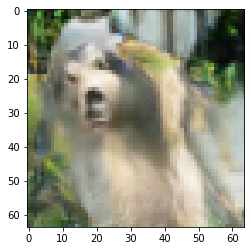

[202/2000][408/692] Loss_D: 0.7208 Loss_G: 1.8032 D(x): 0.6512 D(G(z)): 0.0920 / 0.0932



[203/2000][216/692] Loss_D: 0.8367 Loss_G: 2.0905 D(x): 0.7426 D(G(z)): 0.1437 / 0.0628



[204/2000][24/692] Loss_D: 0.8491 Loss_G: 2.3006 D(x): 0.4502 D(G(z)): 0.0531 / 0.0531
[204/2000][524/692] Loss_D: 0.8081 Loss_G: 2.3949 D(x): 0.5425 D(G(z)): 0.0683 / 0.0427



[205/2000][332/692] Loss_D: 0.7987 Loss_G: 2.4151 D(x): 0.5519 D(G(z)): 0.0846 / 0.0435



[206/2000][140/692] Loss_D: 0.8188 Loss_G: 2.3022 D(x): 0.7044 D(G(z)): 0.1012 / 0.0461
[206/2000][640/692] Loss_D: 0.7071 Loss_G: 1.7802 D(x): 0.6592 D(G(z)): 0.0970 / 0.0989



[207/2000][448/692] Loss_D: 0.7452 Loss_G: 2.3967 D(x): 0.5702 D(G(z)): 0.0535 / 0.0422



[208/2000][256/692] Loss_D: 0.7077 Loss_G: 2.0265 D(x): 0.6785 D(G(z)): 0.0894 / 0.0699



[209/2000][64/692] Loss_D: 0.7184 Loss_G: 1.9732 D(x): 0.6787 D(G(z)): 0.0931 / 0.0822
[209/2000][564/692] Loss_D: 0.7697 Loss_G: 2.0609 D(x): 0.6349 D(G(z)): 0.0773 / 0.0659



[210/2000][372/692] Loss_D: 0.7503 Loss_G: 2.2511 D(x): 0.5566 D(G(z)): 0.0621 / 0.0601



[211/2000][180/692] Loss_D: 0.9275 Loss_G: 3.0015 D(x): 0.7104 D(G(z)): 0.1639 / 0.0190
[211/2000][680/692] Loss_D: 0.7600 Loss_G: 1.9543 D(x): 0.5255 D(G(z)): 0.0544 / 0.0784



[212/2000][488/692] Loss_D: 0.8259 Loss_G: 2.2432 D(x): 0.6137 D(G(z)): 0.1001 / 0.0506



[213/2000][296/692] Loss_D: 0.8689 Loss_G: 2.5324 D(x): 0.7682 D(G(z)): 0.1657 / 0.0348



[214/2000][104/692] Loss_D: 0.7132 Loss_G: 1.8355 D(x): 0.6014 D(G(z)): 0.0711 / 0.1024
[214/2000][604/692] Loss_D: 0.8170 Loss_G: 2.0952 D(x): 0.5314 D(G(z)): 0.0792 / 0.0699



[215/2000][412/692] Loss_D: 0.8013 Loss_G: 1.9970 D(x): 0.4880 D(G(z)): 0.0630 / 0.0720



[216/2000][220/692] Loss_D: 0.7035 Loss_G: 1.8611 D(x): 0.6236 D(G(z)): 0.0680 / 0.0843



[217/2000][28/692] Loss_D: 0.6610 Loss_G: 2.0685 D(x): 0.7284 D(G(z)): 0.0923 / 0.0679
[217/2000][528/692] Loss_D: 0.7329 Loss_G: 2.6176 D(x): 0.5805 D(G(z)): 0.0436 / 0.0319



[218/2000][336/692] Loss_D: 0.7229 Loss_G: 2.3807 D(x): 0.6079 D(G(z)): 0.0533 / 0.0485



[219/2000][144/692] Loss_D: 0.7316 Loss_G: 2.1552 D(x): 0.6058 D(G(z)): 0.0678 / 0.0604
[219/2000][644/692] Loss_D: 0.7711 Loss_G: 2.4881 D(x): 0.4863 D(G(z)): 0.0421 / 0.0410



[220/2000][452/692] Loss_D: 0.7010 Loss_G: 2.1149 D(x): 0.6673 D(G(z)): 0.0862 / 0.0770



[221/2000][260/692] Loss_D: 0.7186 Loss_G: 1.7483 D(x): 0.6849 D(G(z)): 0.1285 / 0.1090



[222/2000][68/692] Loss_D: 0.7446 Loss_G: 2.2910 D(x): 0.5662 D(G(z)): 0.0586 / 0.0474
[222/2000][568/692] Loss_D: 0.7738 Loss_G: 1.8081 D(x): 0.5386 D(G(z)): 0.0681 / 0.1026



[223/2000][376/692] Loss_D: 0.7187 Loss_G: 2.0736 D(x): 0.5812 D(G(z)): 0.0561 / 0.0639



[224/2000][184/692] Loss_D: 0.8331 Loss_G: 2.4333 D(x): 0.7543 D(G(z)): 0.1317 / 0.0403
[224/2000][684/692] Loss_D: 0.8137 Loss_G: 2.2800 D(x): 0.5842 D(G(z)): 0.1000 / 0.0578



[225/2000][492/692] Loss_D: 0.7715 Loss_G: 2.2045 D(x): 0.6653 D(G(z)): 0.1039 / 0.0517



[226/2000][300/692] Loss_D: 0.7383 Loss_G: 1.9545 D(x): 0.5701 D(G(z)): 0.0674 / 0.0821



[227/2000][108/692] Loss_D: 0.7238 Loss_G: 2.0329 D(x): 0.6375 D(G(z)): 0.0911 / 0.0727
[227/2000][608/692] Loss_D: 0.7522 Loss_G: 2.0789 D(x): 0.5696 D(G(z)): 0.0677 / 0.0677



[228/2000][416/692] Loss_D: 0.6704 Loss_G: 2.0824 D(x): 0.6662 D(G(z)): 0.0893 / 0.0738



[229/2000][224/692] Loss_D: 0.6881 Loss_G: 2.2703 D(x): 0.6012 D(G(z)): 0.0561 / 0.0583



[230/2000][32/692] Loss_D: 0.7532 Loss_G: 2.4670 D(x): 0.5329 D(G(z)): 0.0440 / 0.0443
[230/2000][532/692] Loss_D: 0.7490 Loss_G: 2.0617 D(x): 0.5741 D(G(z)): 0.0727 / 0.0791



[231/2000][340/692] Loss_D: 0.7721 Loss_G: 2.1469 D(x): 0.6056 D(G(z)): 0.0922 / 0.0584



[232/2000][148/692] Loss_D: 0.7911 Loss_G: 2.2501 D(x): 0.4908 D(G(z)): 0.0395 / 0.0520
[232/2000][648/692] Loss_D: 0.8282 Loss_G: 2.5932 D(x): 0.7062 D(G(z)): 0.1010 / 0.0321



[233/2000][456/692] Loss_D: 0.8114 Loss_G: 2.4578 D(x): 0.6740 D(G(z)): 0.1100 / 0.0368



[234/2000][264/692] Loss_D: 0.7063 Loss_G: 1.8124 D(x): 0.5695 D(G(z)): 0.0489 / 0.0893



[235/2000][72/692] Loss_D: 0.7881 Loss_G: 2.4478 D(x): 0.6750 D(G(z)): 0.0863 / 0.0389
[235/2000][572/692] Loss_D: 0.7442 Loss_G: 1.9668 D(x): 0.6599 D(G(z)): 0.0793 / 0.0749



[236/2000][380/692] Loss_D: 0.7491 Loss_G: 2.1963 D(x): 0.6254 D(G(z)): 0.0706 / 0.0599



[237/2000][188/692] Loss_D: 0.7613 Loss_G: 2.4422 D(x): 0.6004 D(G(z)): 0.0648 / 0.0415
[237/2000][688/692] Loss_D: 0.8068 Loss_G: 2.0314 D(x): 0.6413 D(G(z)): 0.0910 / 0.0721



[238/2000][496/692] Loss_D: 0.6856 Loss_G: 2.1700 D(x): 0.6317 D(G(z)): 0.0616 / 0.0625



[239/2000][304/692] Loss_D: 0.7430 Loss_G: 1.9272 D(x): 0.5379 D(G(z)): 0.0621 / 0.0875



[240/2000][112/692] Loss_D: 0.7074 Loss_G: 2.2840 D(x): 0.6119 D(G(z)): 0.0588 / 0.0540
[240/2000][612/692] Loss_D: 0.6841 Loss_G: 2.2520 D(x): 0.6460 D(G(z)): 0.0543 / 0.0501



[241/2000][420/692] Loss_D: 0.8087 Loss_G: 2.7742 D(x): 0.7124 D(G(z)): 0.0985 / 0.0256



[242/2000][228/692] Loss_D: 0.7043 Loss_G: 1.9716 D(x): 0.7138 D(G(z)): 0.0960 / 0.0802



[243/2000][36/692] Loss_D: 0.7376 Loss_G: 1.9150 D(x): 0.5892 D(G(z)): 0.0723 / 0.0833
[243/2000][536/692] Loss_D: 0.7913 Loss_G: 2.4104 D(x): 0.6208 D(G(z)): 0.0843 / 0.0386



[244/2000][344/692] Loss_D: 0.7554 Loss_G: 2.0592 D(x): 0.5670 D(G(z)): 0.0603 / 0.0708



[245/2000][152/692] Loss_D: 0.7440 Loss_G: 2.2075 D(x): 0.6083 D(G(z)): 0.0632 / 0.0536
[245/2000][652/692] Loss_D: 0.7367 Loss_G: 1.8511 D(x): 0.6096 D(G(z)): 0.0885 / 0.0898



[246/2000][460/692] Loss_D: 0.6866 Loss_G: 2.0428 D(x): 0.6684 D(G(z)): 0.0894 / 0.0734



[247/2000][268/692] Loss_D: 0.7658 Loss_G: 2.3534 D(x): 0.5315 D(G(z)): 0.0500 / 0.0496



[248/2000][76/692] Loss_D: 0.7642 Loss_G: 2.3451 D(x): 0.5683 D(G(z)): 0.0567 / 0.0498
[248/2000][576/692] Loss_D: 0.6852 Loss_G: 2.0564 D(x): 0.5986 D(G(z)): 0.0494 / 0.0643



[249/2000][384/692] Loss_D: 0.7938 Loss_G: 2.1058 D(x): 0.6852 D(G(z)): 0.1054 / 0.0715



[250/2000][192/692] Loss_D: 0.7006 Loss_G: 2.2116 D(x): 0.6457 D(G(z)): 0.0561 / 0.0561



[251/2000][0/692] Loss_D: 0.7362 Loss_G: 2.3459 D(x): 0.6168 D(G(z)): 0.0533 / 0.0479
[251/2000][500/692] Loss_D: 0.7246 Loss_G: 1.7845 D(x): 0.6636 D(G(z)): 0.1002 / 0.1000



[252/2000][308/692] Loss_D: 0.8318 Loss_G: 2.1322 D(x): 0.4519 D(G(z)): 0.0640 / 0.0632



[253/2000][116/692] Loss_D: 0.7299 Loss_G: 2.0332 D(x): 0.7092 D(G(z)): 0.1158 / 0.0699
[253/2000][616/692] Loss_D: 0.7707 Loss_G: 2.1880 D(x): 0.6370 D(G(z)): 0.0875 / 0.0564



[254/2000][424/692] Loss_D: 0.6763 Loss_G: 2.2266 D(x): 0.6275 D(G(z)): 0.0511 / 0.0553



[255/2000][232/692] Loss_D: 0.7840 Loss_G: 2.3690 D(x): 0.6117 D(G(z)): 0.0730 / 0.0490



[256/2000][40/692] Loss_D: 0.6656 Loss_G: 2.2252 D(x): 0.7158 D(G(z)): 0.0773 / 0.0561
[256/2000][540/692] Loss_D: 0.7870 Loss_G: 2.2263 D(x): 0.7518 D(G(z)): 0.0884 / 0.0507



[257/2000][348/692] Loss_D: 0.7342 Loss_G: 2.4797 D(x): 0.6498 D(G(z)): 0.0602 / 0.0411



[258/2000][156/692] Loss_D: 0.7502 Loss_G: 2.3206 D(x): 0.5829 D(G(z)): 0.0606 / 0.0581
[258/2000][656/692] Loss_D: 0.7340 Loss_G: 2.4802 D(x): 0.5504 D(G(z)): 0.0423 / 0.0383



[259/2000][464/692] Loss_D: 0.7265 Loss_G: 2.3348 D(x): 0.6357 D(G(z)): 0.0591 / 0.0465



[260/2000][272/692] Loss_D: 0.7389 Loss_G: 2.4315 D(x): 0.6073 D(G(z)): 0.0639 / 0.0492



[261/2000][80/692] Loss_D: 0.9977 Loss_G: 2.6707 D(x): 0.8231 D(G(z)): 0.2270 / 0.0290
[261/2000][580/692] Loss_D: 0.7729 Loss_G: 2.1082 D(x): 0.5983 D(G(z)): 0.0835 / 0.0651



[262/2000][388/692] Loss_D: 0.7713 Loss_G: 2.4096 D(x): 0.6396 D(G(z)): 0.0771 / 0.0419



[263/2000][196/692] Loss_D: 0.6947 Loss_G: 2.0420 D(x): 0.6684 D(G(z)): 0.0846 / 0.0728



[264/2000][4/692] Loss_D: 0.8303 Loss_G: 2.1249 D(x): 0.4388 D(G(z)): 0.0418 / 0.0642
[264/2000][504/692] Loss_D: 0.7689 Loss_G: 2.5605 D(x): 0.6368 D(G(z)): 0.0635 / 0.0386



[265/2000][312/692] Loss_D: 0.7212 Loss_G: 2.2874 D(x): 0.6570 D(G(z)): 0.0666 / 0.0547



[266/2000][120/692] Loss_D: 0.6838 Loss_G: 2.2242 D(x): 0.6023 D(G(z)): 0.0507 / 0.0656
[266/2000][620/692] Loss_D: 0.7649 Loss_G: 2.2710 D(x): 0.5386 D(G(z)): 0.0463 / 0.0571



[267/2000][428/692] Loss_D: 0.7825 Loss_G: 2.2241 D(x): 0.7294 D(G(z)): 0.0934 / 0.0551



[268/2000][236/692] Loss_D: 0.7461 Loss_G: 2.3302 D(x): 0.5695 D(G(z)): 0.0496 / 0.0469



[269/2000][44/692] Loss_D: 0.7106 Loss_G: 2.3364 D(x): 0.7074 D(G(z)): 0.0619 / 0.0437
[269/2000][544/692] Loss_D: 0.7372 Loss_G: 2.4312 D(x): 0.6096 D(G(z)): 0.0515 / 0.0436



[270/2000][352/692] Loss_D: 0.7012 Loss_G: 2.2537 D(x): 0.7128 D(G(z)): 0.0687 / 0.0561



[271/2000][160/692] Loss_D: 0.6958 Loss_G: 2.0324 D(x): 0.6653 D(G(z)): 0.0972 / 0.0659
[271/2000][660/692] Loss_D: 0.7683 Loss_G: 2.0693 D(x): 0.7849 D(G(z)): 0.1320 / 0.0627



[272/2000][468/692] Loss_D: 0.7094 Loss_G: 2.3143 D(x): 0.6425 D(G(z)): 0.0753 / 0.0475



[273/2000][276/692] Loss_D: 0.7463 Loss_G: 2.2064 D(x): 0.5876 D(G(z)): 0.0589 / 0.0548



[274/2000][84/692] Loss_D: 0.7825 Loss_G: 2.3629 D(x): 0.6155 D(G(z)): 0.0911 / 0.0553
[274/2000][584/692] Loss_D: 0.6539 Loss_G: 2.0907 D(x): 0.6210 D(G(z)): 0.0449 / 0.0645



[275/2000][392/692] Loss_D: 0.6575 Loss_G: 2.0941 D(x): 0.7093 D(G(z)): 0.0847 / 0.0651



[276/2000][200/692] Loss_D: 0.7444 Loss_G: 2.5003 D(x): 0.6198 D(G(z)): 0.0542 / 0.0369



[277/2000][8/692] Loss_D: 0.6659 Loss_G: 2.2862 D(x): 0.6783 D(G(z)): 0.0520 / 0.0497
[277/2000][508/692] Loss_D: 0.7191 Loss_G: 1.9845 D(x): 0.6697 D(G(z)): 0.0962 / 0.0874



[278/2000][316/692] Loss_D: 0.7372 Loss_G: 2.5120 D(x): 0.6168 D(G(z)): 0.0545 / 0.0418



[279/2000][124/692] Loss_D: 0.6541 Loss_G: 2.2995 D(x): 0.6351 D(G(z)): 0.0486 / 0.0524
[279/2000][624/692] Loss_D: 0.6626 Loss_G: 2.2360 D(x): 0.6361 D(G(z)): 0.0502 / 0.0547



[280/2000][432/692] Loss_D: 0.6834 Loss_G: 2.6574 D(x): 0.5948 D(G(z)): 0.0333 / 0.0328



[281/2000][240/692] Loss_D: 0.6944 Loss_G: 1.8904 D(x): 0.6893 D(G(z)): 0.1095 / 0.0810



[282/2000][48/692] Loss_D: 0.7328 Loss_G: 2.1023 D(x): 0.6165 D(G(z)): 0.0576 / 0.0684
[282/2000][548/692] Loss_D: 0.7025 Loss_G: 2.1836 D(x): 0.6850 D(G(z)): 0.0843 / 0.0615



[283/2000][356/692] Loss_D: 0.8074 Loss_G: 2.4607 D(x): 0.7049 D(G(z)): 0.0897 / 0.0382



[284/2000][164/692] Loss_D: 0.7348 Loss_G: 2.2668 D(x): 0.7237 D(G(z)): 0.0765 / 0.0484
[284/2000][664/692] Loss_D: 0.7636 Loss_G: 2.7942 D(x): 0.6257 D(G(z)): 0.0439 / 0.0241



[285/2000][472/692] Loss_D: 0.7389 Loss_G: 2.7524 D(x): 0.6081 D(G(z)): 0.0569 / 0.0296



[286/2000][280/692] Loss_D: 0.7955 Loss_G: 2.5966 D(x): 0.6534 D(G(z)): 0.0721 / 0.0360



[287/2000][88/692] Loss_D: 0.7244 Loss_G: 2.3433 D(x): 0.6216 D(G(z)): 0.0487 / 0.0454
[287/2000][588/692] Loss_D: 0.7106 Loss_G: 2.1993 D(x): 0.5517 D(G(z)): 0.0345 / 0.0608



[288/2000][396/692] Loss_D: 0.6998 Loss_G: 1.8308 D(x): 0.6750 D(G(z)): 0.0981 / 0.0943



[289/2000][204/692] Loss_D: 0.7173 Loss_G: 2.3771 D(x): 0.5892 D(G(z)): 0.0571 / 0.0508



[290/2000][12/692] Loss_D: 0.6327 Loss_G: 2.1726 D(x): 0.6683 D(G(z)): 0.0555 / 0.0587
[290/2000][512/692] Loss_D: 0.6492 Loss_G: 2.2232 D(x): 0.6560 D(G(z)): 0.0587 / 0.0563



[291/2000][320/692] Loss_D: 0.7565 Loss_G: 2.1495 D(x): 0.7824 D(G(z)): 0.1327 / 0.0549



[292/2000][128/692] Loss_D: 0.7563 Loss_G: 2.5214 D(x): 0.5984 D(G(z)): 0.0444 / 0.0350
[292/2000][628/692] Loss_D: 0.7815 Loss_G: 2.3982 D(x): 0.7217 D(G(z)): 0.0904 / 0.0417



[293/2000][436/692] Loss_D: 0.7841 Loss_G: 1.7584 D(x): 0.5149 D(G(z)): 0.0495 / 0.1099



[294/2000][244/692] Loss_D: 0.7292 Loss_G: 2.5023 D(x): 0.5492 D(G(z)): 0.0340 / 0.0402



[295/2000][52/692] Loss_D: 0.7592 Loss_G: 2.4417 D(x): 0.6499 D(G(z)): 0.0599 / 0.0410
[295/2000][552/692] Loss_D: 0.6861 Loss_G: 2.3476 D(x): 0.6479 D(G(z)): 0.0576 / 0.0468



[296/2000][360/692] Loss_D: 0.6655 Loss_G: 1.9528 D(x): 0.7151 D(G(z)): 0.0990 / 0.0774



[297/2000][168/692] Loss_D: 0.7514 Loss_G: 2.4020 D(x): 0.7369 D(G(z)): 0.0669 / 0.0452
[297/2000][668/692] Loss_D: 0.6865 Loss_G: 2.2799 D(x): 0.5821 D(G(z)): 0.0476 / 0.0575



[298/2000][476/692] Loss_D: 0.6816 Loss_G: 2.3308 D(x): 0.6813 D(G(z)): 0.0595 / 0.0470



[299/2000][284/692] Loss_D: 0.6899 Loss_G: 2.4455 D(x): 0.6065 D(G(z)): 0.0457 / 0.0452



[300/2000][92/692] Loss_D: 0.7387 Loss_G: 2.3638 D(x): 0.6265 D(G(z)): 0.0615 / 0.0595
[300/2000][592/692] Loss_D: 0.6084 Loss_G: 2.1451 D(x): 0.6932 D(G(z)): 0.0558 / 0.0603



[301/2000][400/692] Loss_D: 0.7722 Loss_G: 2.6065 D(x): 0.5302 D(G(z)): 0.0444 / 0.0346



[302/2000][208/692] Loss_D: 0.7441 Loss_G: 2.5762 D(x): 0.6300 D(G(z)): 0.0371 / 0.0333



[303/2000][16/692] Loss_D: 0.7873 Loss_G: 2.6195 D(x): 0.5280 D(G(z)): 0.0547 / 0.0367
[303/2000][516/692] Loss_D: 0.8070 Loss_G: 2.4046 D(x): 0.4730 D(G(z)): 0.0301 / 0.0429



[304/2000][324/692] Loss_D: 0.8587 Loss_G: 2.1021 D(x): 0.4101 D(G(z)): 0.0288 / 0.0656



[305/2000][132/692] Loss_D: 0.7220 Loss_G: 2.3839 D(x): 0.6498 D(G(z)): 0.0489 / 0.0433
[305/2000][632/692] Loss_D: 0.7418 Loss_G: 2.3142 D(x): 0.5267 D(G(z)): 0.0359 / 0.0502



[306/2000][440/692] Loss_D: 0.6932 Loss_G: 2.4124 D(x): 0.7043 D(G(z)): 0.0798 / 0.0575



[307/2000][248/692] Loss_D: 0.6944 Loss_G: 2.6719 D(x): 0.6522 D(G(z)): 0.0505 / 0.0365



[308/2000][56/692] Loss_D: 0.7191 Loss_G: 2.1792 D(x): 0.5593 D(G(z)): 0.0435 / 0.0545
[308/2000][556/692] Loss_D: 0.6835 Loss_G: 2.1482 D(x): 0.6875 D(G(z)): 0.0660 / 0.0596



[309/2000][364/692] Loss_D: 0.7058 Loss_G: 2.7807 D(x): 0.6164 D(G(z)): 0.0326 / 0.0306



[310/2000][172/692] Loss_D: 0.6362 Loss_G: 2.2684 D(x): 0.6580 D(G(z)): 0.0525 / 0.0524
[310/2000][672/692] Loss_D: 0.7160 Loss_G: 2.2418 D(x): 0.5814 D(G(z)): 0.0526 / 0.0559



[311/2000][480/692] Loss_D: 0.7849 Loss_G: 2.6969 D(x): 0.5698 D(G(z)): 0.0579 / 0.0341



[312/2000][288/692] Loss_D: 0.7201 Loss_G: 2.1741 D(x): 0.7370 D(G(z)): 0.0934 / 0.0645



[313/2000][96/692] Loss_D: 0.7431 Loss_G: 2.5539 D(x): 0.5507 D(G(z)): 0.0389 / 0.0354
[313/2000][596/692] Loss_D: 0.7522 Loss_G: 2.5852 D(x): 0.5978 D(G(z)): 0.0578 / 0.0335



[314/2000][404/692] Loss_D: 0.7756 Loss_G: 2.3309 D(x): 0.5311 D(G(z)): 0.0476 / 0.0577



[315/2000][212/692] Loss_D: 0.6313 Loss_G: 2.1764 D(x): 0.7436 D(G(z)): 0.0719 / 0.0556



[316/2000][20/692] Loss_D: 0.7349 Loss_G: 2.7352 D(x): 0.6017 D(G(z)): 0.0365 / 0.0275
[316/2000][520/692] Loss_D: 0.7130 Loss_G: 2.1634 D(x): 0.6036 D(G(z)): 0.0583 / 0.0609



[317/2000][328/692] Loss_D: 0.7045 Loss_G: 2.1529 D(x): 0.5831 D(G(z)): 0.0566 / 0.0616



[318/2000][136/692] Loss_D: 0.7293 Loss_G: 2.3044 D(x): 0.7217 D(G(z)): 0.0740 / 0.0528
[318/2000][636/692] Loss_D: 0.7276 Loss_G: 2.7907 D(x): 0.5773 D(G(z)): 0.0336 / 0.0284



[319/2000][444/692] Loss_D: 0.7229 Loss_G: 2.6063 D(x): 0.6692 D(G(z)): 0.0401 / 0.0334



[320/2000][252/692] Loss_D: 0.7334 Loss_G: 2.3847 D(x): 0.6980 D(G(z)): 0.0519 / 0.0444



[321/2000][60/692] Loss_D: 0.6864 Loss_G: 2.6483 D(x): 0.6724 D(G(z)): 0.0512 / 0.0324
[321/2000][560/692] Loss_D: 0.7808 Loss_G: 2.4519 D(x): 0.7769 D(G(z)): 0.1259 / 0.0412



[322/2000][368/692] Loss_D: 0.7879 Loss_G: 2.0217 D(x): 0.5080 D(G(z)): 0.0482 / 0.0755



[323/2000][176/692] Loss_D: 0.7080 Loss_G: 2.1312 D(x): 0.5891 D(G(z)): 0.0534 / 0.0698
[323/2000][676/692] Loss_D: 0.7629 Loss_G: 2.1188 D(x): 0.5485 D(G(z)): 0.0505 / 0.0702



[324/2000][484/692] Loss_D: 0.7656 Loss_G: 2.8492 D(x): 0.6609 D(G(z)): 0.0545 / 0.0247



[325/2000][292/692] Loss_D: 0.7428 Loss_G: 2.4391 D(x): 0.6342 D(G(z)): 0.0538 / 0.0451



[326/2000][100/692] Loss_D: 0.7367 Loss_G: 2.3878 D(x): 0.5217 D(G(z)): 0.0280 / 0.0449
[326/2000][600/692] Loss_D: 0.6835 Loss_G: 2.2583 D(x): 0.6631 D(G(z)): 0.0607 / 0.0537



[327/2000][408/692] Loss_D: 0.7290 Loss_G: 2.7180 D(x): 0.5228 D(G(z)): 0.0295 / 0.0390



[328/2000][216/692] Loss_D: 0.6905 Loss_G: 2.2393 D(x): 0.6355 D(G(z)): 0.0661 / 0.0629



[329/2000][24/692] Loss_D: 0.7011 Loss_G: 2.4088 D(x): 0.6290 D(G(z)): 0.0486 / 0.0474
[329/2000][524/692] Loss_D: 0.7803 Loss_G: 2.3045 D(x): 0.7020 D(G(z)): 0.0801 / 0.0529



[330/2000][332/692] Loss_D: 0.6633 Loss_G: 2.4719 D(x): 0.7174 D(G(z)): 0.0706 / 0.0598



[331/2000][140/692] Loss_D: 0.6649 Loss_G: 2.1863 D(x): 0.7319 D(G(z)): 0.1064 / 0.0568
[331/2000][640/692] Loss_D: 0.7568 Loss_G: 2.6539 D(x): 0.5940 D(G(z)): 0.0624 / 0.0300



[332/2000][448/692] Loss_D: 0.7526 Loss_G: 2.2447 D(x): 0.8086 D(G(z)): 0.1328 / 0.0518



[333/2000][256/692] Loss_D: 0.7690 Loss_G: 2.6685 D(x): 0.7057 D(G(z)): 0.0765 / 0.0280



[334/2000][64/692] Loss_D: 0.7658 Loss_G: 2.5942 D(x): 0.5287 D(G(z)): 0.0384 / 0.0374
[334/2000][564/692] Loss_D: 0.7005 Loss_G: 2.0072 D(x): 0.6010 D(G(z)): 0.0646 / 0.0740



[335/2000][372/692] Loss_D: 0.6637 Loss_G: 2.5430 D(x): 0.6065 D(G(z)): 0.0340 / 0.0400



[336/2000][180/692] Loss_D: 0.6773 Loss_G: 2.5551 D(x): 0.7117 D(G(z)): 0.0511 / 0.0356
[336/2000][680/692] Loss_D: 0.6885 Loss_G: 2.4051 D(x): 0.6775 D(G(z)): 0.0685 / 0.0434



[337/2000][488/692] Loss_D: 0.6231 Loss_G: 2.2966 D(x): 0.7411 D(G(z)): 0.0672 / 0.0565



[338/2000][296/692] Loss_D: 0.7134 Loss_G: 2.4734 D(x): 0.6337 D(G(z)): 0.0509 / 0.0389



[339/2000][104/692] Loss_D: 0.6118 Loss_G: 2.4147 D(x): 0.7160 D(G(z)): 0.0477 / 0.0476
[339/2000][604/692] Loss_D: 0.7028 Loss_G: 2.6605 D(x): 0.6246 D(G(z)): 0.0409 / 0.0338



[340/2000][412/692] Loss_D: 0.7317 Loss_G: 2.6803 D(x): 0.5803 D(G(z)): 0.0335 / 0.0309



[341/2000][220/692] Loss_D: 0.7395 Loss_G: 2.2539 D(x): 0.5364 D(G(z)): 0.0410 / 0.0509



[342/2000][28/692] Loss_D: 0.7635 Loss_G: 2.9226 D(x): 0.5852 D(G(z)): 0.0389 / 0.0229
[342/2000][528/692] Loss_D: 0.7530 Loss_G: 2.3835 D(x): 0.6491 D(G(z)): 0.0707 / 0.0444



[343/2000][336/692] Loss_D: 0.7217 Loss_G: 2.2421 D(x): 0.7936 D(G(z)): 0.1109 / 0.0548



[344/2000][144/692] Loss_D: 0.7781 Loss_G: 2.1999 D(x): 0.5113 D(G(z)): 0.0444 / 0.0596
[344/2000][644/692] Loss_D: 0.7949 Loss_G: 2.6305 D(x): 0.6615 D(G(z)): 0.0671 / 0.0334



[345/2000][452/692] Loss_D: 0.7165 Loss_G: 2.2379 D(x): 0.5562 D(G(z)): 0.0326 / 0.0567



[346/2000][260/692] Loss_D: 0.7228 Loss_G: 2.3991 D(x): 0.5772 D(G(z)): 0.0412 / 0.0456



[347/2000][68/692] Loss_D: 0.6842 Loss_G: 2.2838 D(x): 0.5927 D(G(z)): 0.0477 / 0.0580
[347/2000][568/692] Loss_D: 0.7475 Loss_G: 2.9818 D(x): 0.6189 D(G(z)): 0.0317 / 0.0224



[348/2000][376/692] Loss_D: 0.7250 Loss_G: 2.3627 D(x): 0.5344 D(G(z)): 0.0347 / 0.0439



[349/2000][184/692] Loss_D: 0.7024 Loss_G: 2.4080 D(x): 0.5802 D(G(z)): 0.0402 / 0.0450
[349/2000][684/692] Loss_D: 0.6152 Loss_G: 2.4208 D(x): 0.6722 D(G(z)): 0.0464 / 0.0479



[350/2000][492/692] Loss_D: 0.6534 Loss_G: 2.5766 D(x): 0.6063 D(G(z)): 0.0344 / 0.0349



[351/2000][300/692] Loss_D: 0.8356 Loss_G: 2.0431 D(x): 0.4566 D(G(z)): 0.0351 / 0.0795



[352/2000][108/692] Loss_D: 0.7294 Loss_G: 2.7288 D(x): 0.6287 D(G(z)): 0.0515 / 0.0310
[352/2000][608/692] Loss_D: 0.7002 Loss_G: 2.0882 D(x): 0.6097 D(G(z)): 0.0483 / 0.0642



[353/2000][416/692] Loss_D: 0.7431 Loss_G: 2.3017 D(x): 0.7176 D(G(z)): 0.0848 / 0.0492



[354/2000][224/692] Loss_D: 0.7484 Loss_G: 2.2546 D(x): 0.6120 D(G(z)): 0.0494 / 0.0581



[355/2000][32/692] Loss_D: 0.7637 Loss_G: 2.3432 D(x): 0.6439 D(G(z)): 0.0596 / 0.0484
[355/2000][532/692] Loss_D: 0.7909 Loss_G: 2.7454 D(x): 0.7270 D(G(z)): 0.0570 / 0.0319



[356/2000][340/692] Loss_D: 0.6876 Loss_G: 2.7366 D(x): 0.6389 D(G(z)): 0.0402 / 0.0314



[357/2000][148/692] Loss_D: 0.7302 Loss_G: 2.6625 D(x): 0.6777 D(G(z)): 0.0538 / 0.0336
[357/2000][648/692] Loss_D: 0.6723 Loss_G: 2.4987 D(x): 0.5834 D(G(z)): 0.0304 / 0.0378



[358/2000][456/692] Loss_D: 0.6616 Loss_G: 2.7495 D(x): 0.5781 D(G(z)): 0.0264 / 0.0299



[359/2000][264/692] Loss_D: 0.6426 Loss_G: 2.2725 D(x): 0.7169 D(G(z)): 0.0694 / 0.0569



[360/2000][72/692] Loss_D: 0.5963 Loss_G: 2.4040 D(x): 0.6802 D(G(z)): 0.0424 / 0.0446
[360/2000][572/692] Loss_D: 0.7597 Loss_G: 2.1623 D(x): 0.7139 D(G(z)): 0.0847 / 0.0662



[361/2000][380/692] Loss_D: 0.7296 Loss_G: 2.1826 D(x): 0.6106 D(G(z)): 0.0595 / 0.0544



[362/2000][188/692] Loss_D: 0.7812 Loss_G: 2.5641 D(x): 0.5239 D(G(z)): 0.0476 / 0.0349
[362/2000][688/692] Loss_D: 0.7839 Loss_G: 2.4890 D(x): 0.5348 D(G(z)): 0.0371 / 0.0418



[363/2000][496/692] Loss_D: 0.7544 Loss_G: 1.6518 D(x): 0.5515 D(G(z)): 0.0702 / 0.1223



[364/2000][304/692] Loss_D: 0.7289 Loss_G: 2.4081 D(x): 0.6114 D(G(z)): 0.0569 / 0.0456



[365/2000][112/692] Loss_D: 0.7231 Loss_G: 2.7001 D(x): 0.7716 D(G(z)): 0.0737 / 0.0329
[365/2000][612/692] Loss_D: 0.7215 Loss_G: 2.6338 D(x): 0.5847 D(G(z)): 0.0384 / 0.0340



[366/2000][420/692] Loss_D: 0.7430 Loss_G: 2.7112 D(x): 0.7389 D(G(z)): 0.0602 / 0.0357



[367/2000][228/692] Loss_D: 0.6368 Loss_G: 2.0994 D(x): 0.7352 D(G(z)): 0.0734 / 0.0698



[368/2000][36/692] Loss_D: 0.6925 Loss_G: 2.4810 D(x): 0.7448 D(G(z)): 0.0614 / 0.0416
[368/2000][536/692] Loss_D: 0.6872 Loss_G: 2.3426 D(x): 0.6148 D(G(z)): 0.0489 / 0.0512



[369/2000][344/692] Loss_D: 0.6324 Loss_G: 2.6266 D(x): 0.6903 D(G(z)): 0.0315 / 0.0322



[370/2000][152/692] Loss_D: 0.6135 Loss_G: 2.4090 D(x): 0.6609 D(G(z)): 0.0398 / 0.0444
[370/2000][652/692] Loss_D: 0.6414 Loss_G: 2.4982 D(x): 0.6521 D(G(z)): 0.0438 / 0.0429



[371/2000][460/692] Loss_D: 0.8401 Loss_G: 2.6257 D(x): 0.7168 D(G(z)): 0.0880 / 0.0280



[372/2000][268/692] Loss_D: 0.7128 Loss_G: 2.4723 D(x): 0.5894 D(G(z)): 0.0461 / 0.0401



[373/2000][76/692] Loss_D: 0.7869 Loss_G: 2.0302 D(x): 0.5034 D(G(z)): 0.0371 / 0.0833
[373/2000][576/692] Loss_D: 0.7734 Loss_G: 2.5435 D(x): 0.5056 D(G(z)): 0.0347 / 0.0425



[374/2000][384/692] Loss_D: 0.6753 Loss_G: 2.2864 D(x): 0.5991 D(G(z)): 0.0395 / 0.0560



[375/2000][192/692] Loss_D: 0.7580 Loss_G: 2.7329 D(x): 0.5351 D(G(z)): 0.0348 / 0.0328



[376/2000][0/692] Loss_D: 0.8228 Loss_G: 2.6629 D(x): 0.7305 D(G(z)): 0.0732 / 0.0304
[376/2000][500/692] Loss_D: 0.7156 Loss_G: 2.4208 D(x): 0.7346 D(G(z)): 0.0814 / 0.0406



[377/2000][308/692] Loss_D: 0.6554 Loss_G: 2.2116 D(x): 0.6810 D(G(z)): 0.0599 / 0.0601



[378/2000][116/692] Loss_D: 0.6761 Loss_G: 2.3541 D(x): 0.7140 D(G(z)): 0.0503 / 0.0427
[378/2000][616/692] Loss_D: 0.6880 Loss_G: 2.5042 D(x): 0.5779 D(G(z)): 0.0372 / 0.0417



[379/2000][424/692] Loss_D: 0.7102 Loss_G: 2.4076 D(x): 0.5541 D(G(z)): 0.0376 / 0.0473



[380/2000][232/692] Loss_D: 0.7451 Loss_G: 2.6785 D(x): 0.7075 D(G(z)): 0.0363 / 0.0291



[381/2000][40/692] Loss_D: 0.8140 Loss_G: 2.9104 D(x): 0.7743 D(G(z)): 0.0964 / 0.0199
[381/2000][540/692] Loss_D: 0.8456 Loss_G: 2.6503 D(x): 0.7946 D(G(z)): 0.1083 / 0.0311



[382/2000][348/692] Loss_D: 0.7759 Loss_G: 2.3622 D(x): 0.5297 D(G(z)): 0.0577 / 0.0512



[383/2000][156/692] Loss_D: 0.7343 Loss_G: 2.1787 D(x): 0.5841 D(G(z)): 0.0418 / 0.0707
[383/2000][656/692] Loss_D: 0.7640 Loss_G: 2.1539 D(x): 0.5363 D(G(z)): 0.0642 / 0.0652



[384/2000][464/692] Loss_D: 0.7471 Loss_G: 2.5601 D(x): 0.5678 D(G(z)): 0.0436 / 0.0338



[385/2000][272/692] Loss_D: 0.7155 Loss_G: 2.6156 D(x): 0.6043 D(G(z)): 0.0296 / 0.0380



[386/2000][80/692] Loss_D: 0.6632 Loss_G: 2.1106 D(x): 0.5941 D(G(z)): 0.0382 / 0.0714
[386/2000][580/692] Loss_D: 0.7753 Loss_G: 2.7018 D(x): 0.6435 D(G(z)): 0.0552 / 0.0349



[387/2000][388/692] Loss_D: 0.7044 Loss_G: 2.7246 D(x): 0.7226 D(G(z)): 0.0595 / 0.0339



[388/2000][196/692] Loss_D: 0.7326 Loss_G: 2.6753 D(x): 0.6584 D(G(z)): 0.0409 / 0.0339



[389/2000][4/692] Loss_D: 0.6778 Loss_G: 2.5493 D(x): 0.6223 D(G(z)): 0.0381 / 0.0378
[389/2000][504/692] Loss_D: 0.6682 Loss_G: 2.5519 D(x): 0.6731 D(G(z)): 0.0416 / 0.0395



[390/2000][312/692] Loss_D: 0.7081 Loss_G: 2.6035 D(x): 0.6231 D(G(z)): 0.0451 / 0.0400



[391/2000][120/692] Loss_D: 0.8224 Loss_G: 2.9547 D(x): 0.8061 D(G(z)): 0.1100 / 0.0184
[391/2000][620/692] Loss_D: 0.6648 Loss_G: 2.3102 D(x): 0.6694 D(G(z)): 0.0602 / 0.0455



[392/2000][428/692] Loss_D: 0.6323 Loss_G: 2.2508 D(x): 0.6794 D(G(z)): 0.0483 / 0.0520



[393/2000][236/692] Loss_D: 0.7688 Loss_G: 2.4545 D(x): 0.5474 D(G(z)): 0.0292 / 0.0417



[394/2000][44/692] Loss_D: 0.7043 Loss_G: 2.4973 D(x): 0.6072 D(G(z)): 0.0469 / 0.0405
[394/2000][544/692] Loss_D: 0.6784 Loss_G: 2.3833 D(x): 0.5957 D(G(z)): 0.0406 / 0.0493



[395/2000][352/692] Loss_D: 0.6482 Loss_G: 2.4936 D(x): 0.7150 D(G(z)): 0.0553 / 0.0397



[396/2000][160/692] Loss_D: 0.6438 Loss_G: 2.6561 D(x): 0.6850 D(G(z)): 0.0397 / 0.0293
[396/2000][660/692] Loss_D: 0.7128 Loss_G: 2.2825 D(x): 0.7080 D(G(z)): 0.0781 / 0.0510



[397/2000][468/692] Loss_D: 0.6376 Loss_G: 2.4075 D(x): 0.6605 D(G(z)): 0.0482 / 0.0492



[398/2000][276/692] Loss_D: 0.7193 Loss_G: 2.3365 D(x): 0.7187 D(G(z)): 0.0775 / 0.0592



[399/2000][84/692] Loss_D: 0.7070 Loss_G: 2.8093 D(x): 0.6007 D(G(z)): 0.0315 / 0.0279
[399/2000][584/692] Loss_D: 0.6085 Loss_G: 2.4690 D(x): 0.6506 D(G(z)): 0.0360 / 0.0392



[400/2000][392/692] Loss_D: 0.6968 Loss_G: 2.6305 D(x): 0.6217 D(G(z)): 0.0383 / 0.0356



[401/2000][200/692] Loss_D: 0.7090 Loss_G: 2.4333 D(x): 0.5922 D(G(z)): 0.0529 / 0.0417



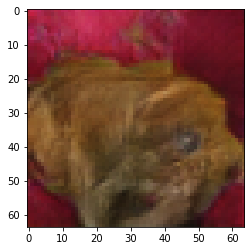

[402/2000][8/692] Loss_D: 0.7832 Loss_G: 2.7157 D(x): 0.7159 D(G(z)): 0.0565 / 0.0264
[402/2000][508/692] Loss_D: 0.6825 Loss_G: 2.6086 D(x): 0.7399 D(G(z)): 0.0598 / 0.0337



[403/2000][316/692] Loss_D: 0.8050 Loss_G: 2.6927 D(x): 0.6882 D(G(z)): 0.0656 / 0.0289



[404/2000][124/692] Loss_D: 0.7208 Loss_G: 2.6731 D(x): 0.6146 D(G(z)): 0.0514 / 0.0299
[404/2000][624/692] Loss_D: 0.7627 Loss_G: 2.7312 D(x): 0.6204 D(G(z)): 0.0442 / 0.0309



[405/2000][432/692] Loss_D: 0.7763 Loss_G: 2.8696 D(x): 0.7358 D(G(z)): 0.0495 / 0.0215



[406/2000][240/692] Loss_D: 0.7576 Loss_G: 2.5889 D(x): 0.6185 D(G(z)): 0.0431 / 0.0337



[407/2000][48/692] Loss_D: 0.7087 Loss_G: 2.6745 D(x): 0.6574 D(G(z)): 0.0376 / 0.0267
[407/2000][548/692] Loss_D: 0.7079 Loss_G: 2.6073 D(x): 0.6572 D(G(z)): 0.0444 / 0.0406



[408/2000][356/692] Loss_D: 0.7249 Loss_G: 2.7420 D(x): 0.6007 D(G(z)): 0.0365 / 0.0309



[409/2000][164/692] Loss_D: 0.6642 Loss_G: 2.5987 D(x): 0.6356 D(G(z)): 0.0418 / 0.0403
[409/2000][664/692] Loss_D: 0.6688 Loss_G: 2.4526 D(x): 0.6745 D(G(z)): 0.0480 / 0.0443



[410/2000][472/692] Loss_D: 0.6217 Loss_G: 2.5193 D(x): 0.6821 D(G(z)): 0.0410 / 0.0409



[411/2000][280/692] Loss_D: 0.7855 Loss_G: 2.7428 D(x): 0.6642 D(G(z)): 0.0550 / 0.0264



[412/2000][88/692] Loss_D: 0.8558 Loss_G: 2.7633 D(x): 0.7174 D(G(z)): 0.0790 / 0.0270
[412/2000][588/692] Loss_D: 0.6719 Loss_G: 2.0468 D(x): 0.6331 D(G(z)): 0.0592 / 0.0718



[413/2000][396/692] Loss_D: 0.7657 Loss_G: 2.6275 D(x): 0.7489 D(G(z)): 0.0796 / 0.0337



[414/2000][204/692] Loss_D: 0.7716 Loss_G: 2.7028 D(x): 0.4879 D(G(z)): 0.0293 / 0.0342



[415/2000][12/692] Loss_D: 0.7143 Loss_G: 2.9061 D(x): 0.6223 D(G(z)): 0.0316 / 0.0203
[415/2000][512/692] Loss_D: 0.6984 Loss_G: 2.3063 D(x): 0.6535 D(G(z)): 0.0460 / 0.0597



[416/2000][320/692] Loss_D: 0.7599 Loss_G: 2.8611 D(x): 0.6869 D(G(z)): 0.0324 / 0.0226



[417/2000][128/692] Loss_D: 0.6698 Loss_G: 2.4369 D(x): 0.6069 D(G(z)): 0.0436 / 0.0528
[417/2000][628/692] Loss_D: 0.6703 Loss_G: 2.3804 D(x): 0.7034 D(G(z)): 0.0499 / 0.0428



[418/2000][436/692] Loss_D: 0.6581 Loss_G: 2.4618 D(x): 0.6261 D(G(z)): 0.0357 / 0.0438



[419/2000][244/692] Loss_D: 0.7615 Loss_G: 2.2481 D(x): 0.7051 D(G(z)): 0.0759 / 0.0562



[420/2000][52/692] Loss_D: 0.6618 Loss_G: 2.5081 D(x): 0.6041 D(G(z)): 0.0349 / 0.0396
[420/2000][552/692] Loss_D: 0.7128 Loss_G: 2.5847 D(x): 0.6196 D(G(z)): 0.0510 / 0.0414



[421/2000][360/692] Loss_D: 0.7191 Loss_G: 2.6075 D(x): 0.6364 D(G(z)): 0.0537 / 0.0333



[422/2000][168/692] Loss_D: 0.7666 Loss_G: 2.6453 D(x): 0.5288 D(G(z)): 0.0356 / 0.0348
[422/2000][668/692] Loss_D: 0.6882 Loss_G: 2.3191 D(x): 0.5882 D(G(z)): 0.0359 / 0.0505



[423/2000][476/692] Loss_D: 0.6669 Loss_G: 2.3561 D(x): 0.7063 D(G(z)): 0.0662 / 0.0515



[424/2000][284/692] Loss_D: 0.6525 Loss_G: 2.0185 D(x): 0.6591 D(G(z)): 0.0577 / 0.0837



[425/2000][92/692] Loss_D: 0.6989 Loss_G: 2.4453 D(x): 0.7483 D(G(z)): 0.0731 / 0.0419
[425/2000][592/692] Loss_D: 0.7009 Loss_G: 2.8751 D(x): 0.6986 D(G(z)): 0.0467 / 0.0310



[426/2000][400/692] Loss_D: 0.6290 Loss_G: 2.5208 D(x): 0.6848 D(G(z)): 0.0459 / 0.0474



[427/2000][208/692] Loss_D: 0.6283 Loss_G: 2.4919 D(x): 0.6682 D(G(z)): 0.0415 / 0.0423



[428/2000][16/692] Loss_D: 0.6896 Loss_G: 2.4221 D(x): 0.6099 D(G(z)): 0.0378 / 0.0409
[428/2000][516/692] Loss_D: 0.7326 Loss_G: 2.8676 D(x): 0.6040 D(G(z)): 0.0357 / 0.0247



[429/2000][324/692] Loss_D: 0.6786 Loss_G: 2.8225 D(x): 0.6417 D(G(z)): 0.0291 / 0.0290



[430/2000][132/692] Loss_D: 0.6975 Loss_G: 2.3199 D(x): 0.6547 D(G(z)): 0.0603 / 0.0513
[430/2000][632/692] Loss_D: 0.6143 Loss_G: 2.8612 D(x): 0.6578 D(G(z)): 0.0291 / 0.0272



[431/2000][440/692] Loss_D: 0.6833 Loss_G: 2.4139 D(x): 0.6844 D(G(z)): 0.0573 / 0.0411



[432/2000][248/692] Loss_D: 0.7151 Loss_G: 2.3942 D(x): 0.5778 D(G(z)): 0.0439 / 0.0484



[433/2000][56/692] Loss_D: 0.7141 Loss_G: 2.2776 D(x): 0.7177 D(G(z)): 0.0720 / 0.0489
[433/2000][556/692] Loss_D: 0.7488 Loss_G: 2.7470 D(x): 0.7064 D(G(z)): 0.0478 / 0.0278



[434/2000][364/692] Loss_D: 0.7605 Loss_G: 3.0059 D(x): 0.6158 D(G(z)): 0.0391 / 0.0225



[435/2000][172/692] Loss_D: 0.7823 Loss_G: 2.5735 D(x): 0.7288 D(G(z)): 0.0622 / 0.0355
[435/2000][672/692] Loss_D: 0.6313 Loss_G: 2.4740 D(x): 0.6769 D(G(z)): 0.0406 / 0.0377



[436/2000][480/692] Loss_D: 0.7160 Loss_G: 2.7038 D(x): 0.5714 D(G(z)): 0.0375 / 0.0345



[437/2000][288/692] Loss_D: 0.7240 Loss_G: 2.5714 D(x): 0.7036 D(G(z)): 0.0481 / 0.0375



[438/2000][96/692] Loss_D: 0.7049 Loss_G: 2.6963 D(x): 0.5967 D(G(z)): 0.0292 / 0.0304
[438/2000][596/692] Loss_D: 0.6141 Loss_G: 2.4669 D(x): 0.7540 D(G(z)): 0.0506 / 0.0428



[439/2000][404/692] Loss_D: 0.6946 Loss_G: 2.4041 D(x): 0.7509 D(G(z)): 0.0548 / 0.0475



[440/2000][212/692] Loss_D: 0.7272 Loss_G: 2.6650 D(x): 0.6749 D(G(z)): 0.0350 / 0.0315



[441/2000][20/692] Loss_D: 0.7915 Loss_G: 2.6929 D(x): 0.4622 D(G(z)): 0.0433 / 0.0326
[441/2000][520/692] Loss_D: 0.7105 Loss_G: 2.8906 D(x): 0.6980 D(G(z)): 0.0448 / 0.0242



[442/2000][328/692] Loss_D: 0.7651 Loss_G: 2.4680 D(x): 0.7230 D(G(z)): 0.0826 / 0.0380



[443/2000][136/692] Loss_D: 0.7389 Loss_G: 2.5458 D(x): 0.6724 D(G(z)): 0.0642 / 0.0346
[443/2000][636/692] Loss_D: 0.7339 Loss_G: 2.6518 D(x): 0.5232 D(G(z)): 0.0274 / 0.0313



[444/2000][444/692] Loss_D: 0.6683 Loss_G: 2.2472 D(x): 0.5937 D(G(z)): 0.0356 / 0.0582



[445/2000][252/692] Loss_D: 0.7169 Loss_G: 2.4329 D(x): 0.7194 D(G(z)): 0.0764 / 0.0422



[446/2000][60/692] Loss_D: 0.6698 Loss_G: 2.5303 D(x): 0.5992 D(G(z)): 0.0328 / 0.0388
[446/2000][560/692] Loss_D: 0.6839 Loss_G: 2.8174 D(x): 0.6460 D(G(z)): 0.0335 / 0.0297



[447/2000][368/692] Loss_D: 0.6204 Loss_G: 2.6557 D(x): 0.6408 D(G(z)): 0.0270 / 0.0351



[448/2000][176/692] Loss_D: 0.7180 Loss_G: 2.5588 D(x): 0.6754 D(G(z)): 0.0407 / 0.0360
[448/2000][676/692] Loss_D: 0.6373 Loss_G: 2.3900 D(x): 0.6359 D(G(z)): 0.0428 / 0.0494



[449/2000][484/692] Loss_D: 0.7006 Loss_G: 3.0126 D(x): 0.5702 D(G(z)): 0.0239 / 0.0237



[450/2000][292/692] Loss_D: 0.6909 Loss_G: 2.5514 D(x): 0.7136 D(G(z)): 0.0495 / 0.0414



[451/2000][100/692] Loss_D: 0.6848 Loss_G: 2.7255 D(x): 0.6066 D(G(z)): 0.0310 / 0.0305
[451/2000][600/692] Loss_D: 0.6583 Loss_G: 2.0854 D(x): 0.6299 D(G(z)): 0.0510 / 0.0721



[452/2000][408/692] Loss_D: 0.6409 Loss_G: 2.0598 D(x): 0.6795 D(G(z)): 0.0532 / 0.0663



[453/2000][216/692] Loss_D: 0.7204 Loss_G: 2.7226 D(x): 0.7112 D(G(z)): 0.0408 / 0.0316



[454/2000][24/692] Loss_D: 0.7694 Loss_G: 2.5652 D(x): 0.7744 D(G(z)): 0.0854 / 0.0401
[454/2000][524/692] Loss_D: 0.7064 Loss_G: 2.6149 D(x): 0.6660 D(G(z)): 0.0542 / 0.0353



[455/2000][332/692] Loss_D: 0.7383 Loss_G: 2.2986 D(x): 0.5203 D(G(z)): 0.0310 / 0.0558



[456/2000][140/692] Loss_D: 0.9032 Loss_G: 2.7035 D(x): 0.8013 D(G(z)): 0.0899 / 0.0286
[456/2000][640/692] Loss_D: 0.7038 Loss_G: 2.8886 D(x): 0.6427 D(G(z)): 0.0293 / 0.0243



[457/2000][448/692] Loss_D: 0.7348 Loss_G: 2.9767 D(x): 0.7004 D(G(z)): 0.0343 / 0.0197



[458/2000][256/692] Loss_D: 0.6325 Loss_G: 2.5239 D(x): 0.6120 D(G(z)): 0.0310 / 0.0435



[459/2000][64/692] Loss_D: 0.7398 Loss_G: 2.7237 D(x): 0.6284 D(G(z)): 0.0450 / 0.0353
[459/2000][564/692] Loss_D: 0.6149 Loss_G: 2.7174 D(x): 0.6439 D(G(z)): 0.0294 / 0.0310



[460/2000][372/692] Loss_D: 0.6183 Loss_G: 2.4205 D(x): 0.6861 D(G(z)): 0.0454 / 0.0491



[461/2000][180/692] Loss_D: 0.8764 Loss_G: 3.0807 D(x): 0.7297 D(G(z)): 0.1042 / 0.0149
[461/2000][680/692] Loss_D: 0.6727 Loss_G: 2.1575 D(x): 0.6497 D(G(z)): 0.0511 / 0.0648



[462/2000][488/692] Loss_D: 0.7058 Loss_G: 2.5754 D(x): 0.6483 D(G(z)): 0.0427 / 0.0319



[463/2000][296/692] Loss_D: 0.6400 Loss_G: 2.4100 D(x): 0.6947 D(G(z)): 0.0536 / 0.0511



[464/2000][104/692] Loss_D: 0.7488 Loss_G: 2.8136 D(x): 0.6423 D(G(z)): 0.0359 / 0.0252
[464/2000][604/692] Loss_D: 0.7375 Loss_G: 2.5074 D(x): 0.5582 D(G(z)): 0.0346 / 0.0437



[465/2000][412/692] Loss_D: 0.7973 Loss_G: 2.8656 D(x): 0.7105 D(G(z)): 0.0452 / 0.0238



[466/2000][220/692] Loss_D: 0.7381 Loss_G: 2.8700 D(x): 0.6277 D(G(z)): 0.0367 / 0.0252



[467/2000][28/692] Loss_D: 0.7361 Loss_G: 2.6260 D(x): 0.5484 D(G(z)): 0.0350 / 0.0384
[467/2000][528/692] Loss_D: 0.6820 Loss_G: 2.8825 D(x): 0.6386 D(G(z)): 0.0338 / 0.0270



[468/2000][336/692] Loss_D: 0.6701 Loss_G: 2.4592 D(x): 0.5766 D(G(z)): 0.0343 / 0.0459



[469/2000][144/692] Loss_D: 0.7439 Loss_G: 2.6705 D(x): 0.6750 D(G(z)): 0.0499 / 0.0393
[469/2000][644/692] Loss_D: 0.6738 Loss_G: 2.4548 D(x): 0.6618 D(G(z)): 0.0456 / 0.0444



[470/2000][452/692] Loss_D: 0.6565 Loss_G: 2.7139 D(x): 0.6045 D(G(z)): 0.0291 / 0.0306



[471/2000][260/692] Loss_D: 0.7332 Loss_G: 2.2925 D(x): 0.5720 D(G(z)): 0.0410 / 0.0538



[472/2000][68/692] Loss_D: 0.9557 Loss_G: 2.0209 D(x): 0.3696 D(G(z)): 0.0300 / 0.0886
[472/2000][568/692] Loss_D: 0.6884 Loss_G: 2.5482 D(x): 0.6035 D(G(z)): 0.0312 / 0.0342



[473/2000][376/692] Loss_D: 0.6965 Loss_G: 2.4437 D(x): 0.5918 D(G(z)): 0.0349 / 0.0427



[474/2000][184/692] Loss_D: 0.6177 Loss_G: 2.5064 D(x): 0.7272 D(G(z)): 0.0472 / 0.0388
[474/2000][684/692] Loss_D: 0.7231 Loss_G: 2.7581 D(x): 0.5753 D(G(z)): 0.0337 / 0.0318



[475/2000][492/692] Loss_D: 0.6811 Loss_G: 2.6738 D(x): 0.6802 D(G(z)): 0.0403 / 0.0362



[476/2000][300/692] Loss_D: 0.7312 Loss_G: 2.7454 D(x): 0.6348 D(G(z)): 0.0423 / 0.0332



[477/2000][108/692] Loss_D: 0.7722 Loss_G: 2.7426 D(x): 0.7029 D(G(z)): 0.0406 / 0.0275
[477/2000][608/692] Loss_D: 0.6659 Loss_G: 2.6463 D(x): 0.6583 D(G(z)): 0.0474 / 0.0366



[478/2000][416/692] Loss_D: 0.6275 Loss_G: 2.8494 D(x): 0.6451 D(G(z)): 0.0317 / 0.0295



[479/2000][224/692] Loss_D: 0.6421 Loss_G: 2.3453 D(x): 0.6428 D(G(z)): 0.0426 / 0.0481



[480/2000][32/692] Loss_D: 0.7007 Loss_G: 2.4620 D(x): 0.6970 D(G(z)): 0.0511 / 0.0443
[480/2000][532/692] Loss_D: 0.6154 Loss_G: 2.4642 D(x): 0.6534 D(G(z)): 0.0419 / 0.0457



[481/2000][340/692] Loss_D: 0.6946 Loss_G: 2.4446 D(x): 0.6730 D(G(z)): 0.0517 / 0.0430



[482/2000][148/692] Loss_D: 0.7260 Loss_G: 2.6153 D(x): 0.6891 D(G(z)): 0.0457 / 0.0325
[482/2000][648/692] Loss_D: 0.7570 Loss_G: 2.7103 D(x): 0.5856 D(G(z)): 0.0443 / 0.0313



[483/2000][456/692] Loss_D: 0.7875 Loss_G: 2.5476 D(x): 0.4845 D(G(z)): 0.0352 / 0.0392



[484/2000][264/692] Loss_D: 0.6449 Loss_G: 2.3526 D(x): 0.7104 D(G(z)): 0.0520 / 0.0501



[485/2000][72/692] Loss_D: 0.5954 Loss_G: 2.3918 D(x): 0.7493 D(G(z)): 0.0623 / 0.0503
[485/2000][572/692] Loss_D: 0.6781 Loss_G: 2.6047 D(x): 0.7471 D(G(z)): 0.0576 / 0.0353



[486/2000][380/692] Loss_D: 0.6942 Loss_G: 2.1871 D(x): 0.7548 D(G(z)): 0.0813 / 0.0634



[487/2000][188/692] Loss_D: 0.7433 Loss_G: 2.7713 D(x): 0.6120 D(G(z)): 0.0329 / 0.0280
[487/2000][688/692] Loss_D: 0.6866 Loss_G: 2.8650 D(x): 0.5863 D(G(z)): 0.0227 / 0.0231



[488/2000][496/692] Loss_D: 0.5791 Loss_G: 2.5764 D(x): 0.7178 D(G(z)): 0.0397 / 0.0372



[489/2000][304/692] Loss_D: 0.6121 Loss_G: 2.5262 D(x): 0.6879 D(G(z)): 0.0421 / 0.0412



[490/2000][112/692] Loss_D: 0.6333 Loss_G: 2.6905 D(x): 0.6076 D(G(z)): 0.0270 / 0.0324
[490/2000][612/692] Loss_D: 0.6908 Loss_G: 2.4543 D(x): 0.6114 D(G(z)): 0.0410 / 0.0415



[491/2000][420/692] Loss_D: 0.7040 Loss_G: 2.1830 D(x): 0.5928 D(G(z)): 0.0384 / 0.0632



[492/2000][228/692] Loss_D: 0.8071 Loss_G: 2.9472 D(x): 0.7269 D(G(z)): 0.0703 / 0.0240



[493/2000][36/692] Loss_D: 0.7275 Loss_G: 2.3156 D(x): 0.5825 D(G(z)): 0.0471 / 0.0502
[493/2000][536/692] Loss_D: 0.6404 Loss_G: 2.3867 D(x): 0.6996 D(G(z)): 0.0476 / 0.0477



[494/2000][344/692] Loss_D: 0.8005 Loss_G: 2.7047 D(x): 0.7406 D(G(z)): 0.0802 / 0.0293



[495/2000][152/692] Loss_D: 0.7756 Loss_G: 2.9004 D(x): 0.7239 D(G(z)): 0.0520 / 0.0248
[495/2000][652/692] Loss_D: 0.6456 Loss_G: 2.5129 D(x): 0.6461 D(G(z)): 0.0284 / 0.0428



[496/2000][460/692] Loss_D: 0.7398 Loss_G: 2.5482 D(x): 0.6917 D(G(z)): 0.0412 / 0.0376



[497/2000][268/692] Loss_D: 0.6175 Loss_G: 2.2299 D(x): 0.7151 D(G(z)): 0.0530 / 0.0545



[498/2000][76/692] Loss_D: 0.7303 Loss_G: 3.0588 D(x): 0.6455 D(G(z)): 0.0223 / 0.0182
[498/2000][576/692] Loss_D: 0.5943 Loss_G: 2.7483 D(x): 0.6941 D(G(z)): 0.0334 / 0.0288



[499/2000][384/692] Loss_D: 0.6478 Loss_G: 2.3047 D(x): 0.6721 D(G(z)): 0.0547 / 0.0537



[500/2000][192/692] Loss_D: 0.6384 Loss_G: 2.6015 D(x): 0.6894 D(G(z)): 0.0401 / 0.0362



[501/2000][0/692] Loss_D: 0.6760 Loss_G: 2.6424 D(x): 0.6352 D(G(z)): 0.0374 / 0.0363
[501/2000][500/692] Loss_D: 0.7219 Loss_G: 2.6993 D(x): 0.5892 D(G(z)): 0.0275 / 0.0322



[502/2000][308/692] Loss_D: 0.7602 Loss_G: 2.8261 D(x): 0.6893 D(G(z)): 0.0694 / 0.0247



[503/2000][116/692] Loss_D: 0.7332 Loss_G: 3.0612 D(x): 0.6730 D(G(z)): 0.0290 / 0.0168
[503/2000][616/692] Loss_D: 0.7936 Loss_G: 2.6028 D(x): 0.7348 D(G(z)): 0.0785 / 0.0325



[504/2000][424/692] Loss_D: 0.7845 Loss_G: 2.9410 D(x): 0.7360 D(G(z)): 0.0492 / 0.0209



[505/2000][232/692] Loss_D: 0.7020 Loss_G: 2.4885 D(x): 0.5963 D(G(z)): 0.0341 / 0.0407



[506/2000][40/692] Loss_D: 0.6447 Loss_G: 2.3539 D(x): 0.6454 D(G(z)): 0.0406 / 0.0552
[506/2000][540/692] Loss_D: 0.6709 Loss_G: 2.4897 D(x): 0.5914 D(G(z)): 0.0269 / 0.0385



[507/2000][348/692] Loss_D: 0.7216 Loss_G: 2.6626 D(x): 0.6570 D(G(z)): 0.0453 / 0.0344



[508/2000][156/692] Loss_D: 0.6811 Loss_G: 2.6531 D(x): 0.6137 D(G(z)): 0.0323 / 0.0344
[508/2000][656/692] Loss_D: 0.7186 Loss_G: 2.5605 D(x): 0.6597 D(G(z)): 0.0428 / 0.0395



[509/2000][464/692] Loss_D: 0.5982 Loss_G: 2.8290 D(x): 0.6792 D(G(z)): 0.0249 / 0.0260



[510/2000][272/692] Loss_D: 0.6538 Loss_G: 2.6340 D(x): 0.6505 D(G(z)): 0.0359 / 0.0336



[511/2000][80/692] Loss_D: 0.6697 Loss_G: 2.7636 D(x): 0.7154 D(G(z)): 0.0390 / 0.0247
[511/2000][580/692] Loss_D: 0.9935 Loss_G: 2.8846 D(x): 0.8491 D(G(z)): 0.1524 / 0.0229



[512/2000][388/692] Loss_D: 0.9524 Loss_G: 2.7369 D(x): 0.8346 D(G(z)): 0.0992 / 0.0256



[513/2000][196/692] Loss_D: 0.7006 Loss_G: 2.2141 D(x): 0.7728 D(G(z)): 0.0876 / 0.0527



[514/2000][4/692] Loss_D: 0.7085 Loss_G: 2.4330 D(x): 0.6264 D(G(z)): 0.0499 / 0.0447
[514/2000][504/692] Loss_D: 0.6724 Loss_G: 2.1856 D(x): 0.6734 D(G(z)): 0.0598 / 0.0595



[515/2000][312/692] Loss_D: 0.6768 Loss_G: 2.7099 D(x): 0.6196 D(G(z)): 0.0400 / 0.0334



[516/2000][120/692] Loss_D: 0.7075 Loss_G: 3.2753 D(x): 0.6143 D(G(z)): 0.0267 / 0.0193
[516/2000][620/692] Loss_D: 0.6658 Loss_G: 2.5348 D(x): 0.6814 D(G(z)): 0.0502 / 0.0418



[517/2000][428/692] Loss_D: 0.6695 Loss_G: 2.8520 D(x): 0.7111 D(G(z)): 0.0355 / 0.0266



[518/2000][236/692] Loss_D: 0.7144 Loss_G: 2.9872 D(x): 0.6221 D(G(z)): 0.0236 / 0.0204



[519/2000][44/692] Loss_D: 0.5915 Loss_G: 2.5691 D(x): 0.6860 D(G(z)): 0.0405 / 0.0392
[519/2000][544/692] Loss_D: 0.7425 Loss_G: 2.8217 D(x): 0.7321 D(G(z)): 0.0378 / 0.0287



[520/2000][352/692] Loss_D: 0.6195 Loss_G: 2.5309 D(x): 0.6733 D(G(z)): 0.0427 / 0.0456



[521/2000][160/692] Loss_D: 0.6650 Loss_G: 2.6840 D(x): 0.6426 D(G(z)): 0.0357 / 0.0346
[521/2000][660/692] Loss_D: 0.7162 Loss_G: 2.3259 D(x): 0.6663 D(G(z)): 0.0515 / 0.0452



[522/2000][468/692] Loss_D: 0.7131 Loss_G: 2.6510 D(x): 0.5929 D(G(z)): 0.0338 / 0.0296



[523/2000][276/692] Loss_D: 0.8354 Loss_G: 3.0049 D(x): 0.7467 D(G(z)): 0.0891 / 0.0213



[524/2000][84/692] Loss_D: 0.7019 Loss_G: 2.3947 D(x): 0.6626 D(G(z)): 0.0516 / 0.0464
[524/2000][584/692] Loss_D: 0.7328 Loss_G: 2.8069 D(x): 0.7115 D(G(z)): 0.0438 / 0.0276



[525/2000][392/692] Loss_D: 0.6370 Loss_G: 2.4269 D(x): 0.6739 D(G(z)): 0.0383 / 0.0424



[526/2000][200/692] Loss_D: 0.7509 Loss_G: 2.4998 D(x): 0.6819 D(G(z)): 0.0638 / 0.0447



[527/2000][8/692] Loss_D: 0.7763 Loss_G: 2.6268 D(x): 0.6990 D(G(z)): 0.0485 / 0.0343
[527/2000][508/692] Loss_D: 0.7201 Loss_G: 2.9675 D(x): 0.6814 D(G(z)): 0.0274 / 0.0224



[528/2000][316/692] Loss_D: 0.6905 Loss_G: 2.4925 D(x): 0.6481 D(G(z)): 0.0413 / 0.0381



[529/2000][124/692] Loss_D: 0.6845 Loss_G: 2.7855 D(x): 0.5758 D(G(z)): 0.0276 / 0.0293
[529/2000][624/692] Loss_D: 0.6819 Loss_G: 3.1260 D(x): 0.6282 D(G(z)): 0.0179 / 0.0166



[530/2000][432/692] Loss_D: 0.6100 Loss_G: 2.5536 D(x): 0.6687 D(G(z)): 0.0402 / 0.0433



[531/2000][240/692] Loss_D: 0.6617 Loss_G: 2.7513 D(x): 0.7513 D(G(z)): 0.0598 / 0.0272



[532/2000][48/692] Loss_D: 0.7365 Loss_G: 2.4215 D(x): 0.6683 D(G(z)): 0.0613 / 0.0410
[532/2000][548/692] Loss_D: 0.7536 Loss_G: 2.4503 D(x): 0.6630 D(G(z)): 0.0600 / 0.0493



[533/2000][356/692] Loss_D: 0.6831 Loss_G: 2.4032 D(x): 0.7141 D(G(z)): 0.0662 / 0.0442



[534/2000][164/692] Loss_D: 0.7661 Loss_G: 2.9192 D(x): 0.6398 D(G(z)): 0.0459 / 0.0252
[534/2000][664/692] Loss_D: 0.6317 Loss_G: 2.6939 D(x): 0.6701 D(G(z)): 0.0360 / 0.0264



[535/2000][472/692] Loss_D: 0.7288 Loss_G: 2.8230 D(x): 0.6370 D(G(z)): 0.0449 / 0.0297



[536/2000][280/692] Loss_D: 0.6150 Loss_G: 2.6155 D(x): 0.6728 D(G(z)): 0.0340 / 0.0337



[537/2000][88/692] Loss_D: 0.6193 Loss_G: 2.8342 D(x): 0.6450 D(G(z)): 0.0283 / 0.0327
[537/2000][588/692] Loss_D: 0.7162 Loss_G: 3.1310 D(x): 0.6128 D(G(z)): 0.0266 / 0.0175



[538/2000][396/692] Loss_D: 0.6233 Loss_G: 2.7748 D(x): 0.6601 D(G(z)): 0.0252 / 0.0291



[539/2000][204/692] Loss_D: 0.7230 Loss_G: 2.8978 D(x): 0.7271 D(G(z)): 0.0315 / 0.0230



[540/2000][12/692] Loss_D: 0.7242 Loss_G: 2.6573 D(x): 0.6163 D(G(z)): 0.0399 / 0.0343
[540/2000][512/692] Loss_D: 0.7057 Loss_G: 2.8933 D(x): 0.6565 D(G(z)): 0.0231 / 0.0229



[541/2000][320/692] Loss_D: 0.6618 Loss_G: 2.7775 D(x): 0.6556 D(G(z)): 0.0288 / 0.0251



[542/2000][128/692] Loss_D: 0.6943 Loss_G: 2.4781 D(x): 0.7238 D(G(z)): 0.0529 / 0.0474
[542/2000][628/692] Loss_D: 0.7089 Loss_G: 2.4768 D(x): 0.6370 D(G(z)): 0.0604 / 0.0456



[543/2000][436/692] Loss_D: 0.7324 Loss_G: 2.4732 D(x): 0.5505 D(G(z)): 0.0382 / 0.0443



[544/2000][244/692] Loss_D: 0.7014 Loss_G: 2.4383 D(x): 0.5989 D(G(z)): 0.0324 / 0.0385



[545/2000][52/692] Loss_D: 0.7477 Loss_G: 2.9007 D(x): 0.5518 D(G(z)): 0.0305 / 0.0257
[545/2000][552/692] Loss_D: 0.7143 Loss_G: 2.6952 D(x): 0.5845 D(G(z)): 0.0333 / 0.0348



[546/2000][360/692] Loss_D: 0.7141 Loss_G: 2.6450 D(x): 0.6621 D(G(z)): 0.0309 / 0.0288



[547/2000][168/692] Loss_D: 0.6008 Loss_G: 2.6058 D(x): 0.6949 D(G(z)): 0.0334 / 0.0346
[547/2000][668/692] Loss_D: 0.6736 Loss_G: 2.5650 D(x): 0.7684 D(G(z)): 0.0440 / 0.0336



[548/2000][476/692] Loss_D: 0.7728 Loss_G: 2.7620 D(x): 0.7447 D(G(z)): 0.0461 / 0.0294



[549/2000][284/692] Loss_D: 0.6069 Loss_G: 2.6600 D(x): 0.6583 D(G(z)): 0.0308 / 0.0294



[550/2000][92/692] Loss_D: 0.6610 Loss_G: 2.7981 D(x): 0.6485 D(G(z)): 0.0341 / 0.0311
[550/2000][592/692] Loss_D: 0.6467 Loss_G: 2.6342 D(x): 0.6870 D(G(z)): 0.0328 / 0.0350



[551/2000][400/692] Loss_D: 0.7299 Loss_G: 2.6922 D(x): 0.7575 D(G(z)): 0.0568 / 0.0279



[552/2000][208/692] Loss_D: 0.6590 Loss_G: 2.4475 D(x): 0.6466 D(G(z)): 0.0344 / 0.0419



[553/2000][16/692] Loss_D: 0.7720 Loss_G: 2.7836 D(x): 0.7709 D(G(z)): 0.0637 / 0.0246
[553/2000][516/692] Loss_D: 0.7073 Loss_G: 2.6988 D(x): 0.6302 D(G(z)): 0.0407 / 0.0315



[554/2000][324/692] Loss_D: 0.7542 Loss_G: 3.1257 D(x): 0.6509 D(G(z)): 0.0268 / 0.0177



[555/2000][132/692] Loss_D: 0.8153 Loss_G: 2.8578 D(x): 0.7923 D(G(z)): 0.0555 / 0.0239
[555/2000][632/692] Loss_D: 0.7128 Loss_G: 2.3364 D(x): 0.5700 D(G(z)): 0.0469 / 0.0554



[556/2000][440/692] Loss_D: 0.6777 Loss_G: 2.4931 D(x): 0.7159 D(G(z)): 0.0496 / 0.0432



[557/2000][248/692] Loss_D: 0.7833 Loss_G: 2.6583 D(x): 0.7235 D(G(z)): 0.0515 / 0.0325



[558/2000][56/692] Loss_D: 0.6495 Loss_G: 2.9623 D(x): 0.6518 D(G(z)): 0.0219 / 0.0216
[558/2000][556/692] Loss_D: 0.7651 Loss_G: 2.5359 D(x): 0.7304 D(G(z)): 0.0573 / 0.0398



[559/2000][364/692] Loss_D: 0.6627 Loss_G: 2.7358 D(x): 0.6718 D(G(z)): 0.0308 / 0.0322



[560/2000][172/692] Loss_D: 0.6785 Loss_G: 2.8705 D(x): 0.6695 D(G(z)): 0.0303 / 0.0265
[560/2000][672/692] Loss_D: 0.7546 Loss_G: 2.5267 D(x): 0.6683 D(G(z)): 0.0504 / 0.0444



[561/2000][480/692] Loss_D: 0.6407 Loss_G: 2.3890 D(x): 0.6634 D(G(z)): 0.0441 / 0.0461



[562/2000][288/692] Loss_D: 0.7388 Loss_G: 2.5336 D(x): 0.7367 D(G(z)): 0.0775 / 0.0400



[563/2000][96/692] Loss_D: 0.7853 Loss_G: 2.6926 D(x): 0.7536 D(G(z)): 0.0686 / 0.0326
[563/2000][596/692] Loss_D: 0.6154 Loss_G: 2.5827 D(x): 0.6722 D(G(z)): 0.0286 / 0.0333



[564/2000][404/692] Loss_D: 0.6939 Loss_G: 2.4621 D(x): 0.6875 D(G(z)): 0.0351 / 0.0452



[565/2000][212/692] Loss_D: 0.6958 Loss_G: 2.5834 D(x): 0.5954 D(G(z)): 0.0364 / 0.0417



[566/2000][20/692] Loss_D: 0.7589 Loss_G: 2.9256 D(x): 0.7455 D(G(z)): 0.0420 / 0.0249
[566/2000][520/692] Loss_D: 0.8238 Loss_G: 2.7209 D(x): 0.7774 D(G(z)): 0.0539 / 0.0297



[567/2000][328/692] Loss_D: 0.7285 Loss_G: 3.0186 D(x): 0.6468 D(G(z)): 0.0295 / 0.0244



[568/2000][136/692] Loss_D: 0.7210 Loss_G: 2.8715 D(x): 0.6926 D(G(z)): 0.0413 / 0.0313
[568/2000][636/692] Loss_D: 0.6975 Loss_G: 2.7745 D(x): 0.5877 D(G(z)): 0.0365 / 0.0361



[569/2000][444/692] Loss_D: 0.6674 Loss_G: 2.6491 D(x): 0.6810 D(G(z)): 0.0447 / 0.0392



[570/2000][252/692] Loss_D: 0.6207 Loss_G: 2.5359 D(x): 0.7219 D(G(z)): 0.0470 / 0.0445



[571/2000][60/692] Loss_D: 0.6118 Loss_G: 2.1007 D(x): 0.7696 D(G(z)): 0.0705 / 0.0670
[571/2000][560/692] Loss_D: 0.7200 Loss_G: 3.1026 D(x): 0.6173 D(G(z)): 0.0267 / 0.0172



[572/2000][368/692] Loss_D: 0.8374 Loss_G: 2.9240 D(x): 0.7428 D(G(z)): 0.0667 / 0.0210



[573/2000][176/692] Loss_D: 0.8948 Loss_G: 2.8947 D(x): 0.7816 D(G(z)): 0.0967 / 0.0219
[573/2000][676/692] Loss_D: 0.7015 Loss_G: 2.1375 D(x): 0.6805 D(G(z)): 0.0604 / 0.0627



[574/2000][484/692] Loss_D: 0.7280 Loss_G: 2.7335 D(x): 0.6187 D(G(z)): 0.0447 / 0.0315



[575/2000][292/692] Loss_D: 0.7292 Loss_G: 2.7173 D(x): 0.5393 D(G(z)): 0.0276 / 0.0334



[576/2000][100/692] Loss_D: 0.7542 Loss_G: 3.0109 D(x): 0.6905 D(G(z)): 0.0368 / 0.0221
[576/2000][600/692] Loss_D: 0.6100 Loss_G: 2.4682 D(x): 0.6714 D(G(z)): 0.0409 / 0.0455



[577/2000][408/692] Loss_D: 0.7165 Loss_G: 2.7951 D(x): 0.5934 D(G(z)): 0.0376 / 0.0353



[578/2000][216/692] Loss_D: 0.6550 Loss_G: 2.9295 D(x): 0.6016 D(G(z)): 0.0181 / 0.0227



[579/2000][24/692] Loss_D: 0.6666 Loss_G: 2.7518 D(x): 0.6936 D(G(z)): 0.0370 / 0.0331
[579/2000][524/692] Loss_D: 0.6629 Loss_G: 2.6188 D(x): 0.6563 D(G(z)): 0.0302 / 0.0315



[580/2000][332/692] Loss_D: 0.7112 Loss_G: 2.8207 D(x): 0.6701 D(G(z)): 0.0350 / 0.0302



[581/2000][140/692] Loss_D: 0.7578 Loss_G: 3.2537 D(x): 0.6522 D(G(z)): 0.0396 / 0.0142
[581/2000][640/692] Loss_D: 0.7130 Loss_G: 2.5110 D(x): 0.5667 D(G(z)): 0.0391 / 0.0436



[582/2000][448/692] Loss_D: 0.7506 Loss_G: 2.6379 D(x): 0.7398 D(G(z)): 0.0662 / 0.0315



[583/2000][256/692] Loss_D: 0.6630 Loss_G: 2.5046 D(x): 0.7319 D(G(z)): 0.0526 / 0.0373



[584/2000][64/692] Loss_D: 0.7076 Loss_G: 2.3912 D(x): 0.7313 D(G(z)): 0.0803 / 0.0461
[584/2000][564/692] Loss_D: 0.7336 Loss_G: 2.7751 D(x): 0.6086 D(G(z)): 0.0298 / 0.0238



[585/2000][372/692] Loss_D: 0.7707 Loss_G: 2.5720 D(x): 0.6939 D(G(z)): 0.0836 / 0.0410



[586/2000][180/692] Loss_D: 0.6712 Loss_G: 2.5356 D(x): 0.6632 D(G(z)): 0.0385 / 0.0388
[586/2000][680/692] Loss_D: 0.7356 Loss_G: 3.0630 D(x): 0.5326 D(G(z)): 0.0244 / 0.0230



[587/2000][488/692] Loss_D: 0.6243 Loss_G: 2.5574 D(x): 0.6444 D(G(z)): 0.0417 / 0.0436



[588/2000][296/692] Loss_D: 0.6930 Loss_G: 2.6546 D(x): 0.6024 D(G(z)): 0.0367 / 0.0355



[589/2000][104/692] Loss_D: 0.6992 Loss_G: 2.9230 D(x): 0.6941 D(G(z)): 0.0279 / 0.0244
[589/2000][604/692] Loss_D: 0.6278 Loss_G: 2.7620 D(x): 0.6223 D(G(z)): 0.0281 / 0.0341



[590/2000][412/692] Loss_D: 0.6032 Loss_G: 2.7435 D(x): 0.6745 D(G(z)): 0.0389 / 0.0371



[591/2000][220/692] Loss_D: 0.6253 Loss_G: 2.4716 D(x): 0.7801 D(G(z)): 0.0783 / 0.0408



[592/2000][28/692] Loss_D: 0.7076 Loss_G: 2.3393 D(x): 0.6357 D(G(z)): 0.0408 / 0.0499
[592/2000][528/692] Loss_D: 0.7068 Loss_G: 2.7605 D(x): 0.5953 D(G(z)): 0.0332 / 0.0302



[593/2000][336/692] Loss_D: 0.7317 Loss_G: 2.7891 D(x): 0.6748 D(G(z)): 0.0452 / 0.0248



[594/2000][144/692] Loss_D: 0.6927 Loss_G: 2.9790 D(x): 0.6211 D(G(z)): 0.0316 / 0.0238
[594/2000][644/692] Loss_D: 0.7437 Loss_G: 2.6422 D(x): 0.5978 D(G(z)): 0.0555 / 0.0385



[595/2000][452/692] Loss_D: 0.7391 Loss_G: 2.7729 D(x): 0.6589 D(G(z)): 0.0486 / 0.0255



[596/2000][260/692] Loss_D: 0.7336 Loss_G: 3.0099 D(x): 0.5904 D(G(z)): 0.0281 / 0.0222



[597/2000][68/692] Loss_D: 0.6155 Loss_G: 2.6948 D(x): 0.6560 D(G(z)): 0.0262 / 0.0327
[597/2000][568/692] Loss_D: 0.6702 Loss_G: 2.6571 D(x): 0.8087 D(G(z)): 0.0387 / 0.0278



[598/2000][376/692] Loss_D: 0.5891 Loss_G: 2.4481 D(x): 0.7535 D(G(z)): 0.0480 / 0.0381



[599/2000][184/692] Loss_D: 0.6741 Loss_G: 2.8948 D(x): 0.6753 D(G(z)): 0.0310 / 0.0286
[599/2000][684/692] Loss_D: 0.6413 Loss_G: 2.4824 D(x): 0.6300 D(G(z)): 0.0433 / 0.0470



[600/2000][492/692] Loss_D: 0.6454 Loss_G: 2.6880 D(x): 0.6693 D(G(z)): 0.0326 / 0.0315



[601/2000][300/692] Loss_D: 0.7192 Loss_G: 2.6191 D(x): 0.5790 D(G(z)): 0.0319 / 0.0339



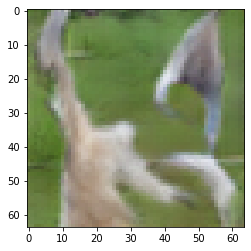

[602/2000][108/692] Loss_D: 0.7325 Loss_G: 2.7453 D(x): 0.6556 D(G(z)): 0.0348 / 0.0265
[602/2000][608/692] Loss_D: 0.8512 Loss_G: 2.5190 D(x): 0.4497 D(G(z)): 0.0267 / 0.0517



[603/2000][416/692] Loss_D: 0.7131 Loss_G: 2.4057 D(x): 0.7029 D(G(z)): 0.0801 / 0.0452



[604/2000][224/692] Loss_D: 0.7688 Loss_G: 2.9674 D(x): 0.6398 D(G(z)): 0.0292 / 0.0235



[605/2000][32/692] Loss_D: 0.8514 Loss_G: 2.9383 D(x): 0.7875 D(G(z)): 0.0625 / 0.0270
[605/2000][532/692] Loss_D: 0.6610 Loss_G: 2.8993 D(x): 0.6330 D(G(z)): 0.0223 / 0.0207



[606/2000][340/692] Loss_D: 0.6580 Loss_G: 2.4340 D(x): 0.6665 D(G(z)): 0.0590 / 0.0500



[607/2000][148/692] Loss_D: 0.6462 Loss_G: 2.7067 D(x): 0.6415 D(G(z)): 0.0375 / 0.0379
[607/2000][648/692] Loss_D: 0.7377 Loss_G: 2.9999 D(x): 0.6606 D(G(z)): 0.0284 / 0.0206



[608/2000][456/692] Loss_D: 0.7012 Loss_G: 2.7123 D(x): 0.6522 D(G(z)): 0.0334 / 0.0326



[609/2000][264/692] Loss_D: 0.6345 Loss_G: 2.5988 D(x): 0.6611 D(G(z)): 0.0312 / 0.0338



[610/2000][72/692] Loss_D: 0.7026 Loss_G: 2.7568 D(x): 0.6479 D(G(z)): 0.0456 / 0.0389
[610/2000][572/692] Loss_D: 0.6903 Loss_G: 2.7104 D(x): 0.6227 D(G(z)): 0.0443 / 0.0374



[611/2000][380/692] Loss_D: 0.6407 Loss_G: 2.5167 D(x): 0.6489 D(G(z)): 0.0318 / 0.0382



[612/2000][188/692] Loss_D: 0.6409 Loss_G: 2.3171 D(x): 0.7175 D(G(z)): 0.0785 / 0.0488
[612/2000][688/692] Loss_D: 0.7051 Loss_G: 2.6672 D(x): 0.6072 D(G(z)): 0.0269 / 0.0386



[613/2000][496/692] Loss_D: 0.7231 Loss_G: 2.6345 D(x): 0.7571 D(G(z)): 0.0455 / 0.0320



[614/2000][304/692] Loss_D: 0.8467 Loss_G: 2.6954 D(x): 0.7419 D(G(z)): 0.0732 / 0.0311



[615/2000][112/692] Loss_D: 0.7273 Loss_G: 2.9274 D(x): 0.5850 D(G(z)): 0.0302 / 0.0255
[615/2000][612/692] Loss_D: 0.7131 Loss_G: 2.4396 D(x): 0.7303 D(G(z)): 0.0580 / 0.0418



[616/2000][420/692] Loss_D: 0.7065 Loss_G: 2.5796 D(x): 0.5239 D(G(z)): 0.0187 / 0.0354



[617/2000][228/692] Loss_D: 0.8010 Loss_G: 2.7295 D(x): 0.7831 D(G(z)): 0.0641 / 0.0314



[618/2000][36/692] Loss_D: 0.6725 Loss_G: 2.9073 D(x): 0.7005 D(G(z)): 0.0297 / 0.0249
[618/2000][536/692] Loss_D: 0.6156 Loss_G: 2.9879 D(x): 0.7226 D(G(z)): 0.0311 / 0.0254



[619/2000][344/692] Loss_D: 0.6768 Loss_G: 2.8088 D(x): 0.6724 D(G(z)): 0.0331 / 0.0301



[620/2000][152/692] Loss_D: 0.7164 Loss_G: 2.8916 D(x): 0.5752 D(G(z)): 0.0297 / 0.0262
[620/2000][652/692] Loss_D: 0.6845 Loss_G: 2.6147 D(x): 0.6657 D(G(z)): 0.0417 / 0.0372



[621/2000][460/692] Loss_D: 0.9013 Loss_G: 3.3231 D(x): 0.8082 D(G(z)): 0.0769 / 0.0130



[622/2000][268/692] Loss_D: 0.7365 Loss_G: 2.7353 D(x): 0.6491 D(G(z)): 0.0482 / 0.0297



[623/2000][76/692] Loss_D: 0.7234 Loss_G: 2.5572 D(x): 0.7106 D(G(z)): 0.0602 / 0.0398
[623/2000][576/692] Loss_D: 0.7647 Loss_G: 2.7752 D(x): 0.6960 D(G(z)): 0.0425 / 0.0267



[624/2000][384/692] Loss_D: 0.7363 Loss_G: 2.9439 D(x): 0.6468 D(G(z)): 0.0316 / 0.0209



[625/2000][192/692] Loss_D: 0.6559 Loss_G: 2.8685 D(x): 0.6600 D(G(z)): 0.0368 / 0.0278



[626/2000][0/692] Loss_D: 0.6361 Loss_G: 2.8411 D(x): 0.6354 D(G(z)): 0.0199 / 0.0246
[626/2000][500/692] Loss_D: 0.6807 Loss_G: 2.5987 D(x): 0.6466 D(G(z)): 0.0305 / 0.0352



[627/2000][308/692] Loss_D: 0.6846 Loss_G: 2.8998 D(x): 0.6579 D(G(z)): 0.0334 / 0.0275



[628/2000][116/692] Loss_D: 0.6954 Loss_G: 2.9827 D(x): 0.7198 D(G(z)): 0.0325 / 0.0227
[628/2000][616/692] Loss_D: 0.6897 Loss_G: 2.8116 D(x): 0.6638 D(G(z)): 0.0354 / 0.0290



[629/2000][424/692] Loss_D: 0.6621 Loss_G: 2.8230 D(x): 0.6557 D(G(z)): 0.0355 / 0.0307



[630/2000][232/692] Loss_D: 0.6860 Loss_G: 2.9853 D(x): 0.6351 D(G(z)): 0.0283 / 0.0246



[631/2000][40/692] Loss_D: 0.6332 Loss_G: 2.8190 D(x): 0.7197 D(G(z)): 0.0305 / 0.0254
[631/2000][540/692] Loss_D: 0.6762 Loss_G: 2.7157 D(x): 0.7518 D(G(z)): 0.0539 / 0.0277



[632/2000][348/692] Loss_D: 0.7763 Loss_G: 2.7683 D(x): 0.7177 D(G(z)): 0.0702 / 0.0280



[633/2000][156/692] Loss_D: 0.7115 Loss_G: 2.7330 D(x): 0.5504 D(G(z)): 0.0287 / 0.0312
[633/2000][656/692] Loss_D: 0.6456 Loss_G: 2.7503 D(x): 0.7753 D(G(z)): 0.0493 / 0.0271



[634/2000][464/692] Loss_D: 0.7741 Loss_G: 2.6337 D(x): 0.8145 D(G(z)): 0.0718 / 0.0302



[635/2000][272/692] Loss_D: 0.7285 Loss_G: 2.6496 D(x): 0.7326 D(G(z)): 0.0537 / 0.0378



[636/2000][80/692] Loss_D: 0.7261 Loss_G: 2.9587 D(x): 0.6148 D(G(z)): 0.0193 / 0.0192
[636/2000][580/692] Loss_D: 0.6730 Loss_G: 2.7380 D(x): 0.5805 D(G(z)): 0.0228 / 0.0260



[637/2000][388/692] Loss_D: 0.7302 Loss_G: 2.8917 D(x): 0.7522 D(G(z)): 0.0339 / 0.0224



[638/2000][196/692] Loss_D: 0.6192 Loss_G: 2.7296 D(x): 0.6783 D(G(z)): 0.0382 / 0.0392



[639/2000][4/692] Loss_D: 0.7163 Loss_G: 2.9081 D(x): 0.7022 D(G(z)): 0.0391 / 0.0305
[639/2000][504/692] Loss_D: 0.6695 Loss_G: 2.9012 D(x): 0.6574 D(G(z)): 0.0245 / 0.0232



[640/2000][312/692] Loss_D: 0.7233 Loss_G: 2.8599 D(x): 0.5859 D(G(z)): 0.0341 / 0.0287



[641/2000][120/692] Loss_D: 0.6699 Loss_G: 2.6230 D(x): 0.6625 D(G(z)): 0.0544 / 0.0352
[641/2000][620/692] Loss_D: 0.7489 Loss_G: 3.0534 D(x): 0.5217 D(G(z)): 0.0293 / 0.0223



[642/2000][428/692] Loss_D: 0.8168 Loss_G: 2.3249 D(x): 0.4687 D(G(z)): 0.0253 / 0.0511



[643/2000][236/692] Loss_D: 0.8326 Loss_G: 3.0677 D(x): 0.7548 D(G(z)): 0.0429 / 0.0184



[644/2000][44/692] Loss_D: 0.6174 Loss_G: 2.3516 D(x): 0.7622 D(G(z)): 0.0661 / 0.0516
[644/2000][544/692] Loss_D: 0.6730 Loss_G: 3.2001 D(x): 0.6019 D(G(z)): 0.0200 / 0.0156



[645/2000][352/692] Loss_D: 0.7493 Loss_G: 2.7256 D(x): 0.7647 D(G(z)): 0.0588 / 0.0315



[646/2000][160/692] Loss_D: 0.6421 Loss_G: 2.5246 D(x): 0.7696 D(G(z)): 0.0479 / 0.0406
[646/2000][660/692] Loss_D: 0.6620 Loss_G: 2.7997 D(x): 0.5867 D(G(z)): 0.0229 / 0.0307



[647/2000][468/692] Loss_D: 0.7319 Loss_G: 2.8492 D(x): 0.6645 D(G(z)): 0.0312 / 0.0258



[648/2000][276/692] Loss_D: 0.6022 Loss_G: 2.6671 D(x): 0.7738 D(G(z)): 0.0398 / 0.0357



[649/2000][84/692] Loss_D: 0.6717 Loss_G: 2.5331 D(x): 0.6989 D(G(z)): 0.0432 / 0.0381
[649/2000][584/692] Loss_D: 0.7001 Loss_G: 2.9080 D(x): 0.6952 D(G(z)): 0.0272 / 0.0242



[650/2000][392/692] Loss_D: 0.5785 Loss_G: 2.7221 D(x): 0.7011 D(G(z)): 0.0294 / 0.0294



[651/2000][200/692] Loss_D: 0.8278 Loss_G: 2.9782 D(x): 0.7893 D(G(z)): 0.0677 / 0.0201



[652/2000][8/692] Loss_D: 0.6878 Loss_G: 2.5586 D(x): 0.7736 D(G(z)): 0.0479 / 0.0345
[652/2000][508/692] Loss_D: 0.6703 Loss_G: 2.5482 D(x): 0.7480 D(G(z)): 0.0664 / 0.0438



[653/2000][316/692] Loss_D: 0.7062 Loss_G: 2.7801 D(x): 0.7817 D(G(z)): 0.0713 / 0.0285



[654/2000][124/692] Loss_D: 0.6209 Loss_G: 2.4730 D(x): 0.6576 D(G(z)): 0.0372 / 0.0439
[654/2000][624/692] Loss_D: 0.6977 Loss_G: 2.6727 D(x): 0.5581 D(G(z)): 0.0244 / 0.0338



[655/2000][432/692] Loss_D: 0.7012 Loss_G: 2.4427 D(x): 0.7204 D(G(z)): 0.0530 / 0.0418



[656/2000][240/692] Loss_D: 0.7077 Loss_G: 2.5918 D(x): 0.6975 D(G(z)): 0.0493 / 0.0356



[657/2000][48/692] Loss_D: 0.6643 Loss_G: 3.0220 D(x): 0.6392 D(G(z)): 0.0271 / 0.0246
[657/2000][548/692] Loss_D: 0.7023 Loss_G: 2.8510 D(x): 0.6346 D(G(z)): 0.0275 / 0.0238



[658/2000][356/692] Loss_D: 0.6258 Loss_G: 2.9163 D(x): 0.7013 D(G(z)): 0.0261 / 0.0246



[659/2000][164/692] Loss_D: 0.5920 Loss_G: 2.7823 D(x): 0.6591 D(G(z)): 0.0222 / 0.0260
[659/2000][664/692] Loss_D: 0.6962 Loss_G: 2.9491 D(x): 0.6442 D(G(z)): 0.0246 / 0.0237



[660/2000][472/692] Loss_D: 0.6099 Loss_G: 2.6669 D(x): 0.7117 D(G(z)): 0.0374 / 0.0355



[661/2000][280/692] Loss_D: 0.6715 Loss_G: 2.5558 D(x): 0.5778 D(G(z)): 0.0309 / 0.0457



[662/2000][88/692] Loss_D: 0.7371 Loss_G: 2.7379 D(x): 0.6259 D(G(z)): 0.0460 / 0.0270
[662/2000][588/692] Loss_D: 0.6951 Loss_G: 2.9404 D(x): 0.6574 D(G(z)): 0.0371 / 0.0277



[663/2000][396/692] Loss_D: 0.7622 Loss_G: 3.2239 D(x): 0.6248 D(G(z)): 0.0384 / 0.0191



[664/2000][204/692] Loss_D: 0.7710 Loss_G: 2.9218 D(x): 0.7644 D(G(z)): 0.0618 / 0.0268



[665/2000][12/692] Loss_D: 0.7218 Loss_G: 2.8172 D(x): 0.6411 D(G(z)): 0.0313 / 0.0246
[665/2000][512/692] Loss_D: 0.6714 Loss_G: 2.7862 D(x): 0.6387 D(G(z)): 0.0226 / 0.0256



[666/2000][320/692] Loss_D: 0.6721 Loss_G: 2.8266 D(x): 0.7323 D(G(z)): 0.0375 / 0.0288



[667/2000][128/692] Loss_D: 0.6724 Loss_G: 2.8225 D(x): 0.6549 D(G(z)): 0.0399 / 0.0325
[667/2000][628/692] Loss_D: 0.7846 Loss_G: 2.7842 D(x): 0.7555 D(G(z)): 0.0453 / 0.0292



[668/2000][436/692] Loss_D: 0.6702 Loss_G: 2.7258 D(x): 0.7422 D(G(z)): 0.0407 / 0.0315



[669/2000][244/692] Loss_D: 0.5922 Loss_G: 2.7895 D(x): 0.6586 D(G(z)): 0.0310 / 0.0345



[670/2000][52/692] Loss_D: 0.6195 Loss_G: 3.0959 D(x): 0.6649 D(G(z)): 0.0208 / 0.0207
[670/2000][552/692] Loss_D: 0.6422 Loss_G: 2.6489 D(x): 0.7179 D(G(z)): 0.0346 / 0.0330



[671/2000][360/692] Loss_D: 0.7528 Loss_G: 2.7674 D(x): 0.7077 D(G(z)): 0.0541 / 0.0252



[672/2000][168/692] Loss_D: 0.6863 Loss_G: 2.7071 D(x): 0.7421 D(G(z)): 0.0573 / 0.0281
[672/2000][668/692] Loss_D: 0.6168 Loss_G: 2.5856 D(x): 0.7159 D(G(z)): 0.0354 / 0.0386



[673/2000][476/692] Loss_D: 0.7110 Loss_G: 2.7275 D(x): 0.6738 D(G(z)): 0.0510 / 0.0286



[674/2000][284/692] Loss_D: 0.6631 Loss_G: 2.4328 D(x): 0.6186 D(G(z)): 0.0341 / 0.0449



[675/2000][92/692] Loss_D: 0.7320 Loss_G: 2.9309 D(x): 0.5323 D(G(z)): 0.0181 / 0.0218
[675/2000][592/692] Loss_D: 0.7300 Loss_G: 3.1580 D(x): 0.6547 D(G(z)): 0.0260 / 0.0171



[676/2000][400/692] Loss_D: 0.7982 Loss_G: 2.9440 D(x): 0.7901 D(G(z)): 0.0425 / 0.0216



[677/2000][208/692] Loss_D: 0.6948 Loss_G: 2.8623 D(x): 0.6031 D(G(z)): 0.0277 / 0.0293



[678/2000][16/692] Loss_D: 0.7416 Loss_G: 2.7863 D(x): 0.7464 D(G(z)): 0.0454 / 0.0316
[678/2000][516/692] Loss_D: 0.6682 Loss_G: 2.9360 D(x): 0.6228 D(G(z)): 0.0171 / 0.0177



[679/2000][324/692] Loss_D: 0.7058 Loss_G: 3.1056 D(x): 0.6260 D(G(z)): 0.0275 / 0.0210



[680/2000][132/692] Loss_D: 0.6826 Loss_G: 2.8391 D(x): 0.6522 D(G(z)): 0.0286 / 0.0269
[680/2000][632/692] Loss_D: 0.6308 Loss_G: 2.8514 D(x): 0.6907 D(G(z)): 0.0276 / 0.0264



[681/2000][440/692] Loss_D: 0.7321 Loss_G: 2.2581 D(x): 0.8292 D(G(z)): 0.1067 / 0.0555



[682/2000][248/692] Loss_D: 0.7063 Loss_G: 2.5067 D(x): 0.6369 D(G(z)): 0.0350 / 0.0403



[683/2000][56/692] Loss_D: 0.7919 Loss_G: 2.6696 D(x): 0.4687 D(G(z)): 0.0173 / 0.0318
[683/2000][556/692] Loss_D: 0.6454 Loss_G: 2.5820 D(x): 0.6356 D(G(z)): 0.0369 / 0.0474



[684/2000][364/692] Loss_D: 0.7811 Loss_G: 2.9099 D(x): 0.7246 D(G(z)): 0.0505 / 0.0270



[685/2000][172/692] Loss_D: 0.5925 Loss_G: 2.6747 D(x): 0.7274 D(G(z)): 0.0354 / 0.0330
[685/2000][672/692] Loss_D: 0.6554 Loss_G: 2.3839 D(x): 0.6194 D(G(z)): 0.0335 / 0.0473



[686/2000][480/692] Loss_D: 0.6335 Loss_G: 2.6898 D(x): 0.7192 D(G(z)): 0.0360 / 0.0319



[687/2000][288/692] Loss_D: 0.6517 Loss_G: 2.9490 D(x): 0.5986 D(G(z)): 0.0183 / 0.0204



[688/2000][96/692] Loss_D: 0.5999 Loss_G: 2.7356 D(x): 0.6811 D(G(z)): 0.0351 / 0.0341
[688/2000][596/692] Loss_D: 0.7313 Loss_G: 3.1639 D(x): 0.6733 D(G(z)): 0.0201 / 0.0150



[689/2000][404/692] Loss_D: 0.7150 Loss_G: 2.8323 D(x): 0.6832 D(G(z)): 0.0342 / 0.0277



[690/2000][212/692] Loss_D: 0.6310 Loss_G: 2.5141 D(x): 0.6527 D(G(z)): 0.0418 / 0.0435



[691/2000][20/692] Loss_D: 0.6380 Loss_G: 2.9501 D(x): 0.6925 D(G(z)): 0.0347 / 0.0226
[691/2000][520/692] Loss_D: 0.7493 Loss_G: 2.9768 D(x): 0.5157 D(G(z)): 0.0229 / 0.0255



[692/2000][328/692] Loss_D: 0.6018 Loss_G: 2.6507 D(x): 0.7746 D(G(z)): 0.0551 / 0.0387



[693/2000][136/692] Loss_D: 0.6639 Loss_G: 2.3831 D(x): 0.8076 D(G(z)): 0.1081 / 0.0458
[693/2000][636/692] Loss_D: 0.7506 Loss_G: 2.7763 D(x): 0.5551 D(G(z)): 0.0259 / 0.0291



[694/2000][444/692] Loss_D: 0.7758 Loss_G: 2.4754 D(x): 0.5022 D(G(z)): 0.0254 / 0.0396



[695/2000][252/692] Loss_D: 0.6799 Loss_G: 2.5824 D(x): 0.6047 D(G(z)): 0.0313 / 0.0391



KeyboardInterrupt: 

In [ ]:
### training the models

#initialize step=0
step = 0
for epoch in range(epochs):  #iterate through 2000 epochs
    for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)): #iterate through train data
        end = time() # intialize timer
        if (end -start) > 25000 : #break when execution time exceeds a threshhold
            break
        # (1) Update Discrimonator: maximize log(D(x)) + log(1 - D(G(z)))
  
        # train with real
        netD.zero_grad()  #initialize gradients of discriminator to 0 (to free memory)
        #convert tensors to GPU environment
        real_images = real_images.to(device)
        #fix batch size
        batch_size = real_images.size(0)
        #labels corresponding to pictures
        #initialize labels with ones (real labels)
        labels = torch.full((batch_size, 1), real_label, device=device)

        #output from discriminator from real pictures
        output = netD(real_images)
        #calculate error of prediction from disc. for REAL pictures
        errD_real = criterion(output, labels)
        #update discriminator
        errD_real.backward()
        #mean of disc. predictions
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        #result generated by generator from the random noise vector
        fake = netG(noise)
        labels.fill_(fake_label)
        #pass result to discriminator
        output = netD(fake.detach())
        #calculate error by BCE
        errD_fake = criterion(output, labels)
        #update discriminator
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        #error=Real picturess error + fake picturess error
        errD = errD_real + errD_fake
        #optimize loss function
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))

        #optimize generator error
        netG.zero_grad() #initialize gradients of generator to 0 (to free memory)
        labels.fill_(real_label)  # fake labels are real for generator cost
        #predict whether the images generated by the generator are fake or real
        output = netD(fake)
        #calculate error
        errG = criterion(output, labels)
        #update generator params
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        #show progress
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)

    if epoch % 200 == 0:
        show_generated_img()
    

I have stopped the train after 6/7 hoours of training, even though the train could still do better.
\
The error curves (should look like this). Both the generator and discriminator tend to converge to a static state (the eroors almost never change)

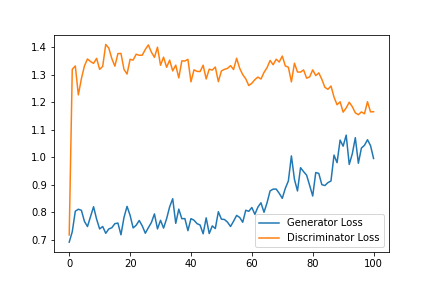

In [ ]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values


#os.mkdir('../output_images') (create output folder in case the directory doesn't exist)
im_batch_size = 100
n_images=10000
#generate images with the trained generator
for i_batch in range(0, n_images, im_batch_size):
    #generate random noise vector
    z = truncated_normal((im_batch_size, 100, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    #save images of the batch
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

#save generated images in an archive file
import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

# Show results

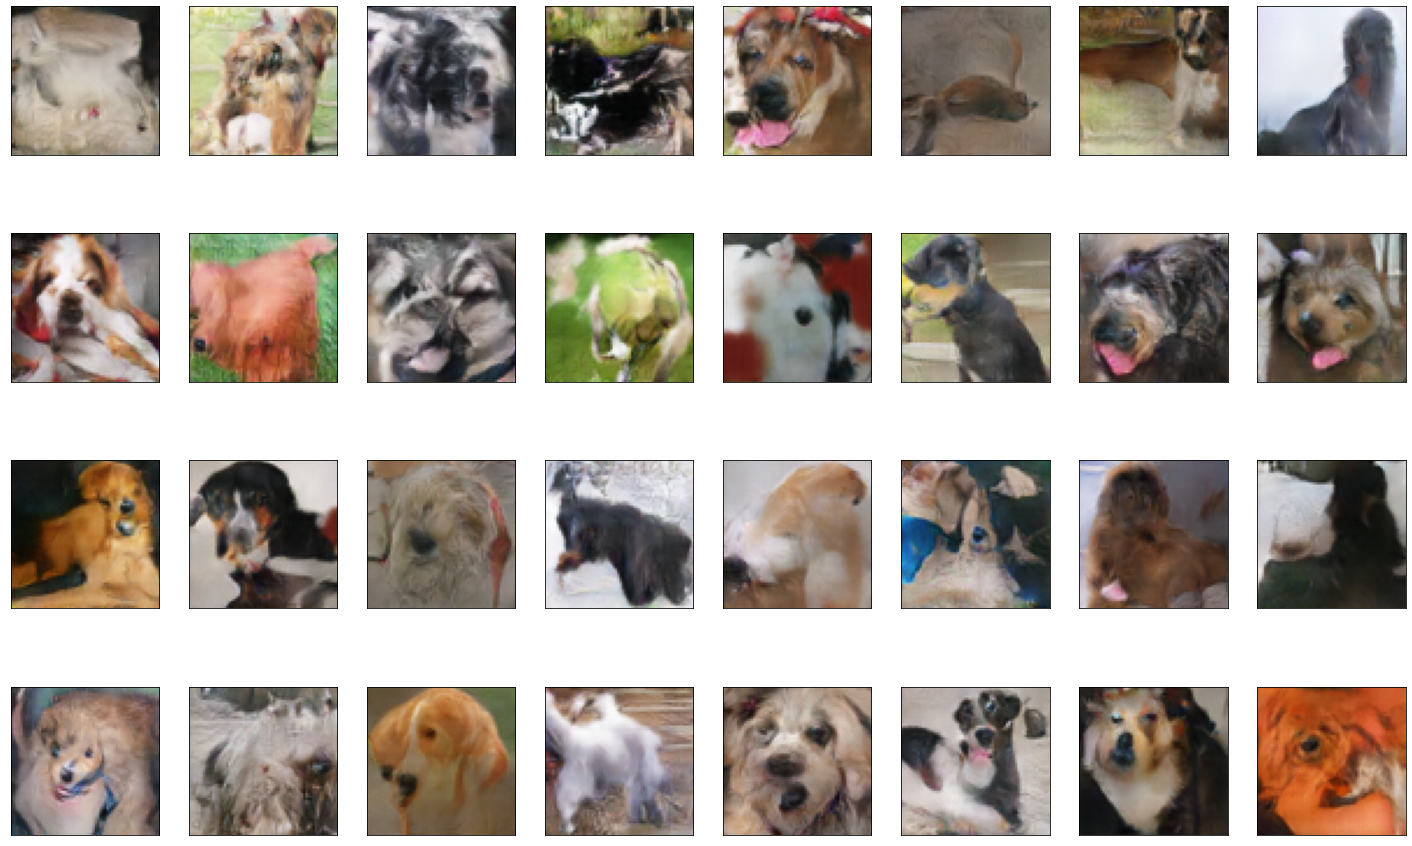

In [ ]:
show_generated_img_all()